# Final Models:

Importing packages:

In [1]:
import pandas as pd
from importlib import reload
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
import seaborn as sns
%config InlineBackend.figure_formats = ['retina']
%matplotlib inline

plt.rcParams['figure.figsize'] = (9, 6)
sns.set(context='notebook', style='whitegrid', font_scale=1.2)

import sklearn

from collections import OrderedDict
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder
from sklearn import datasets
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, precision_recall_curve,f1_score, fbeta_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import log_loss
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

Loading in Functions:

In [8]:
pwd

'/Users/patrickbovard/Documents/GitHub/metis_project_3'

In [9]:
cd Python_Functions

/Users/patrickbovard/Documents/GitHub/metis_project_3/Python_Functions


In [10]:
from knn_model_eval import *

In [3]:
from logistic_reg_model_eval import *

In [4]:
from random_forest_evaluator import *

In [5]:
from xgboost import XGBClassifier

In [6]:
from xgboost_evaluator import *

In [7]:
from xgboost import plot_importance
import xgboost as xgb

Load in the new dataframes:

In [12]:
training_horses_final = pd.read_pickle('../Data/training_horses_final.pkl')

In [13]:
training_horses_final['float_days_since_last_race'] = (training_horses_final['days_since_last_race'].dt.total_seconds()) / (24*60*60)

In [14]:
training_horses_final['career_show_rate'] = training_horses_final['career_shows'] / training_horses_final['career_races']

### One Hot Encoding horse_type:

In [15]:
ohe = OneHotEncoder(drop='first', sparse=False)

In [16]:
training_model_gender_cat = training_horses_final.loc[:, ['horse_type']]

In [17]:
ohe.fit(training_model_gender_cat)

ohe_X = ohe.transform(training_model_gender_cat)

columns = ohe.get_feature_names(['horse_type'])

ohe_X_df = pd.DataFrame(ohe_X, columns=columns, index=training_model_gender_cat.index)

In [18]:
training_horses_final_cleaned = pd.concat([training_horses_final, ohe_X_df], axis=1)

In [19]:
training_horses_final_cleaned.drop(columns='horse_type', inplace=True)

In [20]:
training_horses_final_cleaned.head()

race_id  horse_id  result  lengths_behind  horse_age horse_country  \
2735     6128      3368       1            0.00          3           GER   
2736     6128      1389       2            1.25          4           IRE   
2737     6128       374       3            3.00          4           AUS   
2738     6128      2531       4            4.50          3           AUS   
2739     6128      3955       5            4.50          4           IRE   

      horse_rating  horse_gear  declared_weight  actual_weight  ...  \
2735            73      TT/B/H           1153.0            126  ...   
2736            74          --            980.0            127  ...   
2737            70           B           1116.0            123  ...   
2738            63           B           1115.0            109  ...   
2739            68  H-/SR1/XB1           1068.0            121  ...   

      top_10_jockey  top_10_trainer  three_race_avg_mid_len_gain  \
2735              0               1                   -10.000000   
2736              1               1                    -1.250000   
2737              0               1                     0.666667   
2738              1               0                     0.000000   
2739              0               1                     1.333333   

      float_days_since_last_race  career_show_rate  horse_type_Filly  \
2735                        79.0          1.000000               0.0   
2736                        79.0          0.272727               0.0   
2737                        79.0          0.125000               0.0   
2738                        70.0          0.666667               0.0   
2739                       158.0          0.000000               0.0   

      horse_type_Gelding  horse_type_Horse  horse_type_Mare  horse_type_Rig  
2735                 1.0               0.0              0.0             0.0  
2736                 1.0               0.0              0.0             0.0  
2737                 1.0               0.0              0.0             0.0  
2738                 1.0               0.0              0.0             0.0  
2739                 1.0               0.0              0.0             0.0  

[5 rows x 80 columns]

Country Variables:

In [18]:
training_horses_final_cleaned['AUS'] = 0
training_horses_final_cleaned['NZ'] = 0
training_horses_final_cleaned['IRE'] = 0
training_horses_final_cleaned['GB'] = 0
training_horses_final_cleaned['USA'] = 0
training_horses_final_cleaned['Other'] = 0

In [20]:
for i, value in enumerate(training_horses_final_cleaned['horse_country']):
    if training_horses_final_cleaned.iloc[i, 5] == 'AUS':
        training_horses_final_cleaned.iloc[i, 80] = 1
    elif training_horses_final_cleaned.iloc[i, 5] == 'NZ':
        training_horses_final_cleaned.iloc[i, 81] = 1
    elif training_horses_final_cleaned.iloc[i, 5] == 'IRE':
        training_horses_final_cleaned.iloc[i, 82] = 1
    elif training_horses_final_cleaned.iloc[i, 5] == 'GB':
        training_horses_final_cleaned.iloc[i, 83] = 1
    elif training_horses_final_cleaned.iloc[i, 5] == 'USA':
        training_horses_final_cleaned.iloc[i, 84] = 1
    else:
        training_horses_final_cleaned.iloc[i, 85] = 1

Based on models in race_split_data_test, gear added nothing to the model, so that won't be included.

First, will utilize these columns:

In [21]:
columns = ['AUS','NZ','IRE','GB','USA','Other','horse_age', 'horse_rating', 'declared_weight', 'actual_weight', 'draw',
          'place_odds', 'distance', 'three_race_rolling_avg_finish', 'three_race_rolling_average_lengths', 
          'three_race_rolling_average_time', 'three_race_rolling_average_distance_per_time', 'horses_in_field', 
          'field_rating_rank', 'diff_from_field_rating_avg', 'field_age_rank', 'diff_from_field_age_avg', 
          'diff_from_field_declared_wgt_avg', 'field_dec_wgt_rank', 'diff_from_field_handicap_wgt_avg', 'field_handicap_wgt_rank', 
          'career_races', 'career_shows', 'shows_in_last_5_races', 'three_race_rolling_average_len_len1', 
          'float_days_since_last_race', 'three_race_avg_mid_time', 'top_10_jockey', 'top_10_trainer', 'three_race_avg_mid_len_gain',
          'career_show_rate', 'horse_type_Filly', 'horse_type_Gelding', 'horse_type_Horse', 'horse_type_Mare', 'horse_type_Rig']

In [22]:
X = training_horses_final_cleaned[columns]
y = training_horses_final_cleaned['show']

### Testing out the base models, to make a final decision on my final model:

In [23]:
logreg = log_accuracy_scorer_k_fold(X, y, k=5, threshold=0.5, C=1)

Confusion Matrix for Fold 1
[[8372  216]
 [2429  400]]


Confusion Matrix for Fold 2
[[8404  248]
 [2378  387]]


Confusion Matrix for Fold 3
[[8450  191]
 [2420  356]]


Confusion Matrix for Fold 4
[[8347  254]
 [2436  380]]


Confusion Matrix for Fold 5
[[8382  269]
 [2394  372]]


Logistic Regression Classification w/ KFOLD CV Results (k=5):
Log. Reg Accuracy scores:  [0.7683279320311815, 0.7699921170184812, 0.7713059472716125, 0.7643864412717877, 0.766751335727424] 

Simple mean cv accuracy: 0.768 + 0.002 

Log. Reg Precision scores:  [0.6493506493506493, 0.6094488188976378, 0.6508226691042047, 0.5993690851735016, 0.5803432137285491] 

Simple mean cv precision: 0.618 +- 0.028 

Log. Reg Recall scores:  [0.14139271827500885, 0.1399638336347197, 0.1282420749279539, 0.13494318181818182, 0.13449023861171366] 

Simple mean cv recall: 0.136 +- 0.005 

Log. Reg Fbeta (beta=0.5) scores:  [0.37785754770451535, 0.3647502356267671, 0.3585817888799355, 0.35500747384155457, 0.348968105065666] 


In [27]:
random_forest_eval_kfold(X,y, k=5, threshold = 0.5)

Confusion Matrix for Fold 1
[[8114  474]
 [2148  681]]


Confusion Matrix for Fold 2
[[8128  524]
 [2040  725]]


Confusion Matrix for Fold 3
[[8170  471]
 [2117  659]]


Confusion Matrix for Fold 4
[[8125  476]
 [2132  684]]


Confusion Matrix for Fold 5
[[8138  513]
 [2074  692]]


Random Forest Classification w/ KFOLD CV Results (k=5, threshold = 0.5):
Random Forest Accuracy scores:  [0.7709555925374442, 0.7773495664360165, 0.773846019094333, 0.7710431812209863, 0.7736708417272489] 

Simple mean cv accuracy: 0.773 + 0.002
Random Forest Precision scores:  [0.5896103896103896, 0.5804643714971978, 0.5831858407079646, 0.5896551724137931, 0.5742738589211618] 

Simple mean cv precision: 0.583 +- 0.006
Random Forest Recall scores:  [0.24072110286320256, 0.26220614828209765, 0.23739193083573487, 0.24289772727272727, 0.2501807664497469] 

Simple mean cv recall: 0.247 +- 0.009
Random Forest Fbeta (beta=0.5) scores:  [0.4571083366894885, 0.4670789846669243, 0.4516173245614036, 0.45869098712446

RandomForestClassifier()

In [31]:
xg_model = xgboost_eval_kfold(X,y, k=5, threshold = 0.5)

[08:02:54] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Confusion Matrix for Fold 1
[[8124  464]
 [2117  712]]


[08:03:03] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Confusion Matrix for Fold 2
[[8175  477]
 [2012  753]]


[08:03:13] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_met

Based on XGBoost being only ~.015 off from Log Reg in Precision, with almost double in recall, I am going to focus on XGBoost as my final model.  Additionally, XGBoost is outperforming Random Forest on both metrics.  Additionally, XGBoost can handle multi-class features better than Logistic Regression, so it is the ideal choice.

The thought here is that while I am sacrificing some precision, there is an opportunity cost to missing show predictions.  With the vast increase in recall with a minimal tradeoff in precision, I could be finding horses with longer odds to show, thus increasing my payout.  Additionally, an individual could alter the decision threshold to where they see fit, in terms of betting risk (i.e. raising from 50%).

## FINAL MODEL: XGBoost

Looking at the important features in the XGBoost model w/ threshold of 0.5:

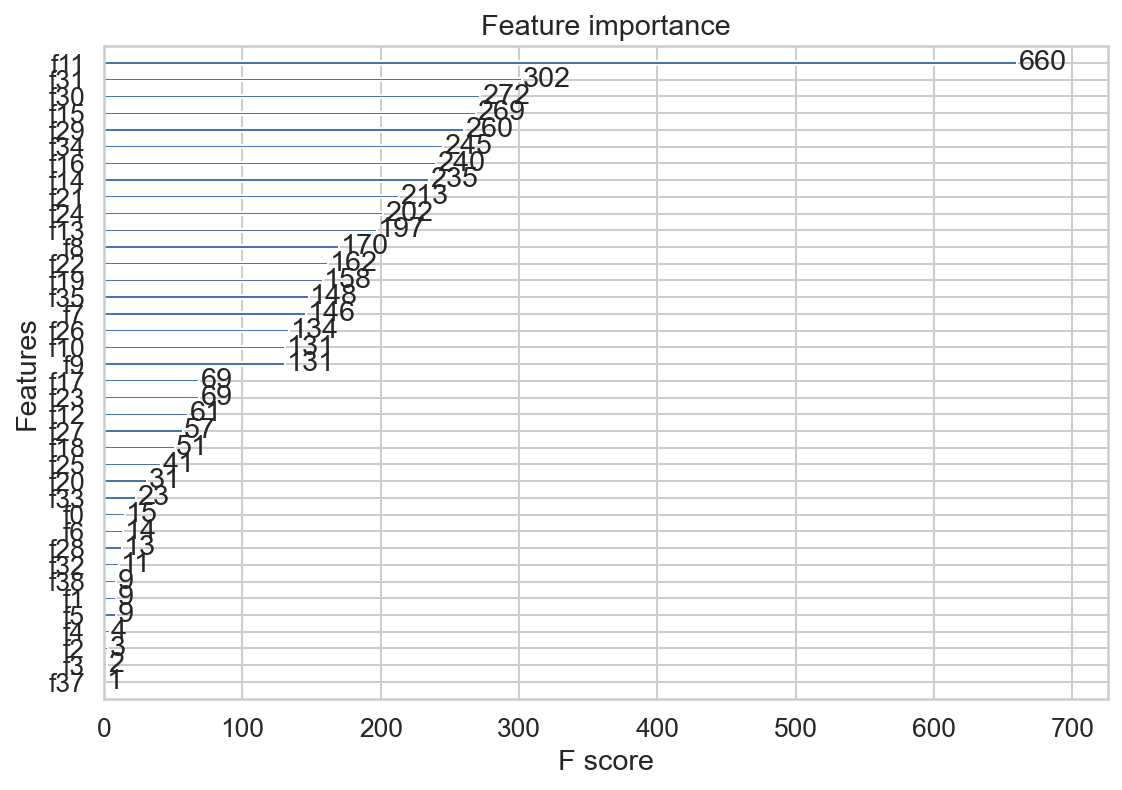

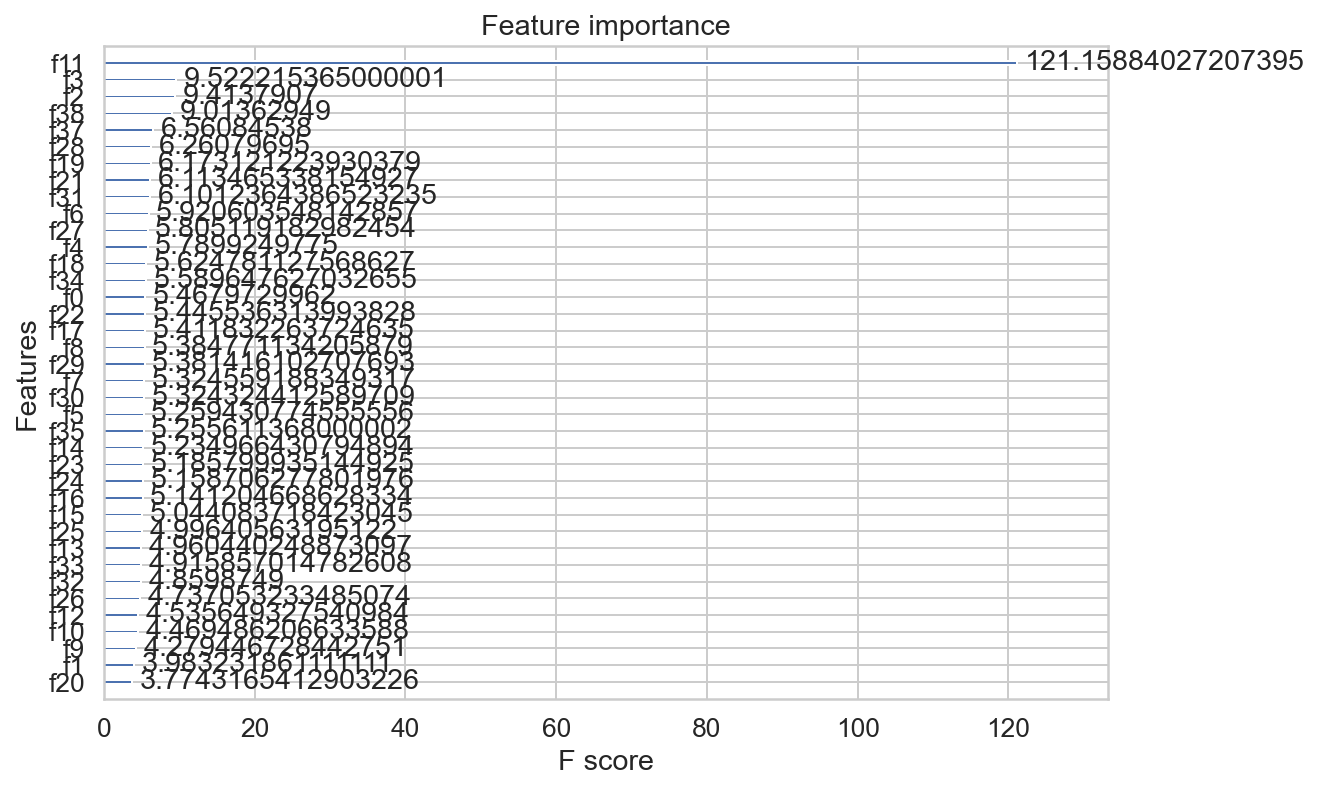

In [32]:
xgb.plot_importance(xg_model)
xgb.plot_importance(xg_model, importance_type='gain');

In [34]:
xg_model.get_booster().feature_names
print('Features for XGBoost:')
for i, column in enumerate(X.columns):
    print('{}: {}'.format(xg_model.get_booster().feature_names[i], column))

Features for XGBoost:
f0: AUS
f1: NZ
f2: IRE
f3: GB
f4: USA
f5: Other
f6: horse_age
f7: horse_rating
f8: declared_weight
f9: actual_weight
f10: draw
f11: place_odds
f12: distance
f13: three_race_rolling_avg_finish
f14: three_race_rolling_average_lengths
f15: three_race_rolling_average_time
f16: three_race_rolling_average_distance_per_time
f17: horses_in_field
f18: field_rating_rank
f19: diff_from_field_rating_avg
f20: field_age_rank
f21: diff_from_field_age_avg
f22: diff_from_field_declared_wgt_avg
f23: field_dec_wgt_rank
f24: diff_from_field_handicap_wgt_avg
f25: field_handicap_wgt_rank
f26: career_races
f27: career_shows
f28: shows_in_last_5_races
f29: three_race_rolling_average_len_len1
f30: float_days_since_last_race
f31: three_race_avg_mid_time
f32: top_10_jockey
f33: top_10_trainer
f34: three_race_avg_mid_len_gain
f35: career_show_rate
f36: horse_type_Filly
f37: horse_type_Gelding
f38: horse_type_Horse
f39: horse_type_Mare
f40: horse_type_Rig


# Featuretools Try:

In order to try to pick up some strong interaction terms, I am going to utilize featuretools to create some new features from my set.  If any show a good deal of importance, I will incorporate into my model and finalize.

In [35]:
import featuretools as ft

In [36]:
X = training_horses_final_cleaned[columns]

In [37]:
es = ft.EntitySet(id = 'horses')

In [39]:
es.entity_from_dataframe(entity_id = 'horses', dataframe = X, make_index = True, index = 'index')

Entityset: horses
  Entities:
    horses [Rows: 57085, Columns: 42]
  Relationships:
    No relationships

In [40]:
feature_matrix, feature_defs = ft.dfs(entityset = es, target_entity = 'horses',
                                      trans_primitives = ['add_numeric', 'multiply_numeric'])

In [41]:
feature_matrix.head()

AUS  NZ  IRE  GB  USA  Other  horse_age  horse_rating  declared_weight  \
index                                                                           
0        0   0    0   0    0      1          3            73           1153.0   
1        0   0    1   0    0      0          4            74            980.0   
2        1   0    0   0    0      0          4            70           1116.0   
3        1   0    0   0    0      0          3            63           1115.0   
4        0   0    1   0    0      0          4            68           1068.0   

       actual_weight  ...  three_race_rolling_average_time * USA  \
index                 ...                                          
0                126  ...                                    0.0   
1                127  ...                                    0.0   
2                123  ...                                    0.0   
3                109  ...                                    0.0   
4                121  ...                                    0.0   

       three_race_rolling_average_time * three_race_rolling_avg_finish  \
index                                                                    
0                                              69.350000                 
1                                             368.346667                 
2                                             547.353333                 
3                                             191.527778                 
4                                             812.933333                 

       three_race_rolling_average_time * top_10_jockey  \
index                                                    
0                                             0.000000   
1                                            92.086667   
2                                             0.000000   
3                                            82.083333   
4                                             0.000000   

       three_race_rolling_average_time * top_10_trainer  \
index                                                     
0                                             69.350000   
1                                             92.086667   
2                                             78.193333   
3                                              0.000000   
4                                             93.800000   

       three_race_rolling_avg_finish * USA  \
index                                        
0                                      0.0   
1                                      0.0   
2                                      0.0   
3                                      0.0   
4                                      0.0   

       three_race_rolling_avg_finish * top_10_jockey  \
index                                                  
0                                           0.000000   
1                                           4.000000   
2                                           0.000000   
3                                           2.333333   
4                                           0.000000   

       three_race_rolling_avg_finish * top_10_trainer  top_10_jockey * USA  \
index                                                                        
0                                            1.000000                    0   
1                                            4.000000                    0   
2                                            7.000000                    0   
3                                            0.000000                    0   
4                                            8.666667                    0   

       top_10_jockey * top_10_trainer  top_10_trainer * USA  
index                                                        
0                                   0                     0  
1                                   1                     0  
2                                   0                     0  
3                                   0            

Running my models with the new features:

In [42]:
Xft = feature_matrix

In [43]:
xg_model = xgboost_eval_kfold(Xft,y, k=5, threshold = 0.5)

[08:05:33] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Confusion Matrix for Fold 1
[[8137  451]
 [2145  684]]


[08:12:43] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Confusion Matrix for Fold 2
[[8165  487]
 [2015  750]]


[08:19:51] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_met

Taking a look at the most important features:

In [59]:
import operator

In [55]:
weight_features = xg_model.get_booster().get_score(importance_type = 'weight')
weight_features

{'f991': 79,
 'f1137': 33,
 'f1619': 59,
 'f1314': 8,
 'f190': 3,
 'f564': 9,
 'f897': 12,
 'f1611': 23,
 'f830': 9,
 'f151': 2,
 'f891': 7,
 'f1317': 27,
 'f1462': 27,
 'f1669': 2,
 'f1455': 13,
 'f786': 7,
 'f254': 3,
 'f1629': 2,
 'f1141': 9,
 'f1371': 4,
 'f1174': 7,
 'f1654': 3,
 'f1506': 16,
 'f545': 2,
 'f423': 26,
 'f784': 5,
 'f1459': 12,
 'f435': 9,
 'f1499': 48,
 'f1145': 15,
 'f1185': 3,
 'f1248': 5,
 'f801': 25,
 'f809': 12,
 'f341': 3,
 'f1356': 9,
 'f1192': 5,
 'f1193': 22,
 'f929': 6,
 'f1487': 4,
 'f799': 37,
 'f798': 40,
 'f174': 6,
 'f1250': 10,
 'f479': 18,
 'f1032': 28,
 'f1031': 11,
 'f1037': 6,
 'f990': 19,
 'f1650': 6,
 'f1189': 5,
 'f1072': 8,
 'f1507': 4,
 'f211': 2,
 'f1245': 8,
 'f1398': 15,
 'f1147': 4,
 'f72': 7,
 'f402': 10,
 'f354': 11,
 'f616': 7,
 'f1300': 6,
 'f848': 5,
 'f269': 3,
 'f1485': 8,
 'f995': 9,
 'f1219': 1,
 'f282': 23,
 'f1543': 2,
 'f1413': 18,
 'f505': 2,
 'f179': 1,
 'f1194': 7,
 'f11': 2,
 'f810': 12,
 'f615': 5,
 'f455': 9,
 'f787': 

SOrting by weight DESC:

In [60]:
sorted_weight = sorted(weight_features.items(), key=operator.itemgetter(1), reverse=True)

In [61]:
sorted_weight

[('f991', 79),
 ('f1619', 59),
 ('f1499', 48),
 ('f798', 40),
 ('f799', 37),
 ('f1137', 33),
 ('f800', 31),
 ('f1032', 28),
 ('f789', 28),
 ('f1317', 27),
 ('f1462', 27),
 ('f423', 26),
 ('f801', 25),
 ('f1136', 25),
 ('f110', 24),
 ('f1611', 23),
 ('f282', 23),
 ('f1193', 22),
 ('f1623', 22),
 ('f483', 22),
 ('f1621', 21),
 ('f827', 20),
 ('f990', 19),
 ('f480', 19),
 ('f839', 19),
 ('f843', 19),
 ('f479', 18),
 ('f1413', 18),
 ('f1647', 18),
 ('f1384', 17),
 ('f200', 17),
 ('f1618', 17),
 ('f1104', 17),
 ('f1506', 16),
 ('f1153', 16),
 ('f123', 16),
 ('f1145', 15),
 ('f1398', 15),
 ('f838', 15),
 ('f234', 15),
 ('f1238', 15),
 ('f661', 15),
 ('f407', 15),
 ('f629', 14),
 ('f1672', 14),
 ('f1329', 14),
 ('f1297', 14),
 ('f1069', 14),
 ('f788', 14),
 ('f1455', 13),
 ('f1656', 13),
 ('f1410', 13),
 ('f1437', 13),
 ('f1206', 13),
 ('f796', 13),
 ('f804', 13),
 ('f509', 13),
 ('f1620', 13),
 ('f1673', 13),
 ('f1461', 13),
 ('f897', 12),
 ('f1459', 12),
 ('f809', 12),
 ('f810', 12),
 ('f78

Features by gain:

In [53]:
gain_features = xg_model.get_booster().get_score(importance_type = 'gain')
gain_features

{'f991': 461.8013316513926,
 'f1137': 178.96978014848492,
 'f1619': 223.2797501471187,
 'f1314': 5.4627236725,
 'f190': 6.796920776666667,
 'f564': 9.391548582222223,
 'f897': 10.743469939166667,
 'f1611': 9.813256308695651,
 'f830': 7.985149864444444,
 'f151': 8.404340744999999,
 'f891': 11.498694558571428,
 'f1317': 12.090095872592592,
 'f1462': 9.682630751111112,
 'f1669': 14.732262599999999,
 'f1455': 13.345944776923078,
 'f786': 10.976341934285715,
 'f254': 11.14763007,
 'f1629': 10.40362453,
 'f1141': 11.094569573333333,
 'f1371': 10.5863714175,
 'f1174': 11.02518681,
 'f1654': 14.567368833333333,
 'f1506': 10.067029378125,
 'f545': 6.9332635400000004,
 'f423': 5.482834381153846,
 'f784': 12.309679028,
 'f1459': 11.820303281666668,
 'f435': 11.78187608111111,
 'f1499': 100.7516537979375,
 'f1145': 8.033163547066666,
 'f1185': 11.08605448,
 'f1248': 12.359472646,
 'f801': 28.299717753200003,
 'f809': 9.396243569166668,
 'f341': 10.788645436666664,
 'f1356': 11.044040258888888,
 'f

In [62]:
sorted_gain = sorted(gain_features.items(), key=operator.itemgetter(1), reverse=True)
sorted_gain

[('f753', 823.13684705),
 ('f11', 516.714386),
 ('f991', 461.8013316513926),
 ('f718', 377.6714931166667),
 ('f795', 263.8759765),
 ('f1619', 223.2797501471187),
 ('f1137', 178.96978014848492),
 ('f106', 149.360851298),
 ('f1604', 139.07049391454544),
 ('f804', 137.00621912923077),
 ('f796', 122.04916013),
 ('f69', 118.51011014999999),
 ('f1499', 100.7516537979375),
 ('f799', 94.44740989297297),
 ('f803', 60.057152179999996),
 ('f246', 39.21495843),
 ('f587', 33.57411362125),
 ('f1538', 28.999527),
 ('f801', 28.299717753200003),
 ('f798', 27.858359406750004),
 ('f1297', 27.562608814285717),
 ('f282', 24.50002950086957),
 ('f800', 21.570653308548383),
 ('f401', 21.4580784),
 ('f993', 19.7514496),
 ('f1622', 19.215659729999995),
 ('f854', 17.9162579),
 ('f972', 17.7126427),
 ('f1418', 17.3731003),
 ('f248', 17.3686142),
 ('f1621', 17.30864245904762),
 ('f1501', 16.460763),
 ('f982', 16.3573761),
 ('f590', 16.0435638),
 ('f998', 15.7926846),
 ('f331', 15.7547989),
 ('f1272', 15.6091645333

Top 5 by Gain: f753, f11, f991, f718, f795, f1619 

Top 5 by Weight: F991, F1619, F1499, F798, F799

In both: 991, 1619.  Also try: f753, F1619, f718, to add 5 features.  What were these?

In [67]:
Xft.iloc[:, 991]

index
0         151.2
1         254.0
2         369.0
3         218.0
4        1089.0
          ...  
57080     130.8
57081     552.0
57082     330.4
57083     235.2
57084    1041.6
Name: actual_weight * place_odds, Length: 57085, dtype: float64

In [72]:
training_horses_final_cleaned['actual_weight * place_odds'] = training_horses_final_cleaned['actual_weight']*training_horses_final_cleaned['place_odds']

In [68]:
Xft.iloc[:, 1619]

index
0         20.764239
1         33.733912
2         51.136269
3         34.113006
4        148.832331
            ...    
57080     19.520852
57081     74.667978
57082     45.485872
57083     35.575992
57084    138.671069
Name: place_odds * three_race_rolling_average_distance_per_time, Length: 57085, dtype: float64

In [74]:
training_horses_final_cleaned['place_odds * three_race_rolling_average_distance_per_time'] = training_horses_final_cleaned['three_race_rolling_average_distance_per_time']*training_horses_final_cleaned['place_odds']

In [69]:
Xft.iloc[:, 1499]

index
0         87.6
1        148.0
2        210.0
3        126.0
4        612.0
         ...  
57080     72.0
57081    276.0
57082    168.0
57083    126.0
57084    504.0
Name: horse_rating * place_odds, Length: 57085, dtype: float64

In [75]:
training_horses_final_cleaned['horse_rating * place_odds'] = training_horses_final_cleaned['horse_rating']*training_horses_final_cleaned['place_odds']

In [70]:
Xft.iloc[:, 798]

index
0        0.020000
1        2.830000
2        4.403333
3        3.983333
4        9.776667
           ...   
57080    1.090000
57081    6.130000
57082    2.650000
57083    3.810000
57084    8.590000
Name: place_odds + three_race_avg_mid_time, Length: 57085, dtype: float64

In [76]:
training_horses_final_cleaned['place_odds + three_race_avg_mid_time'] = training_horses_final_cleaned['three_race_avg_mid_time'] + training_horses_final_cleaned['place_odds']

In [71]:
Xft.iloc[:, 799]

index
0        18.503533
1        18.866956
2        20.045423
3        19.056503
4        25.536926
           ...    
57080    17.467377
57081    20.832169
57082    19.044954
57083    19.040949
57084    24.908461
Name: place_odds + three_race_rolling_average_distance_per_time, Length: 57085, dtype: float64

In [77]:
training_horses_final_cleaned['place_odds + three_race_rolling_average_distance_per_time'] = training_horses_final_cleaned['three_race_rolling_average_distance_per_time'] + training_horses_final_cleaned['place_odds']

Adding these interactions into the main dataframe:

In [121]:
columns_int = ['actual_weight * place_odds', 'place_odds * three_race_rolling_average_distance_per_time', 'horse_rating * place_odds', 'place_odds + three_race_avg_mid_time', 'place_odds + three_race_rolling_average_distance_per_time', 'AUS','NZ','IRE','GB','USA','Other','horse_age', 'horse_rating', 'declared_weight', 'actual_weight', 'draw',
          'place_odds', 'distance', 'three_race_rolling_avg_finish', 'three_race_rolling_average_lengths', 
          'three_race_rolling_average_time', 'three_race_rolling_average_distance_per_time', 'horses_in_field', 
          'field_rating_rank', 'diff_from_field_rating_avg', 'field_age_rank', 'diff_from_field_age_avg', 
          'diff_from_field_declared_wgt_avg', 'field_dec_wgt_rank', 'diff_from_field_handicap_wgt_avg', 'field_handicap_wgt_rank', 
          'career_races', 'career_shows', 'shows_in_last_5_races', 'three_race_rolling_average_len_len1', 
          'float_days_since_last_race', 'three_race_avg_mid_time', 'top_10_jockey', 'top_10_trainer', 'three_race_avg_mid_len_gain',
          'career_show_rate', 'horse_type_Filly', 'horse_type_Gelding', 'horse_type_Horse', 'horse_type_Mare', 'horse_type_Rig']

Using these top 5 terms to plug back into the original model, to see if they add anything:

In [122]:
X_int = training_horses_final_cleaned[columns_int]
y = training_horses_final_cleaned['show']

In [123]:
xg_model_int = xgboost_eval_kfold(X_int,y, k=5, threshold = 0.5)

[09:45:30] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Confusion Matrix for Fold 1
[[8145  443]
 [2151  678]]


[09:46:02] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Confusion Matrix for Fold 2
[[8178  474]
 [2004  761]]


[09:46:36] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_met

This performed very slightly better in precision while maintaining recall - will include in final model.

# Tuning XGBoost

I will be utilizing a RandomizedSearchCV first, to help narrow down the hyperparameter scope for the final features/XGBoost model:

In [124]:
n_estimators = [int(x) for x in np.linspace(start = 50, stop = 300, num = 10)]
max_depth = [2, 3, 4, 5, 6]
learning_rate = [0.05, 0.1, 0.3, 0.5]
subsample = [0.5, 0.75, 1]
min_child_weight = [4,5,6, 7]
colsample_bytree = [0.5, 0.75, 1]

parameters = {'n_estimators':n_estimators, 'max_depth':max_depth, 'learning_rate':learning_rate,
              'subsample':subsample, 'min_child_weight':min_child_weight, 'colsample_bytree':colsample_bytree}

In [125]:
xgb_model = xgb.XGBClassifier(silent=True, objective='binary:logistic')

In [126]:
random_xg = RandomizedSearchCV(xgb_model, param_distributions=parameters, n_iter = 30, cv=5, scoring='precision', n_jobs=-1, random_state=1001, verbose=1)

In [127]:
random_xg.fit(X_int,y)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:20:13] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[10:20:13] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, gamma=None,
                                           gpu_id=None, importance_type='gain',
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           n_estimators=100,...
                                           subsample=None, tree_method=None,
                                           validate_parameters=None,
                                   

In [128]:
print('\n All results:')
print(random_xg.cv_results_)
print('\n Best estimator:')
print(random_xg.best_estimator_)
print('PRecision:')
print(random_xg.best_score_)
print('\n Best hyperparameters:')
print(random_xg.best_params_)


 All results:
{'mean_fit_time': array([ 19.72826142,  67.25312867, 150.66917634,  38.53473306,
        28.00050492,  27.00348539,  10.16749482,   7.92196727,
         7.39684114,  61.02873158,  56.2647408 , 107.20016575,
        37.47755108,  25.24122896,  74.36400733,  17.02326918,
        73.34863095,  52.6725162 , 104.15702682,  23.38406639,
        21.37511358, 137.07205753,  35.68850055,  63.3331296 ,
        20.83085089,  13.42274375,  19.27122364,  44.162148  ,
        68.98471375,  61.65029883]), 'std_fit_time': array([ 0.71408249,  2.44215021,  8.01202173,  1.23765757,  0.597792  ,
        1.17997479,  0.19879555,  0.24004623,  0.07364779,  1.49089929,
        7.58354144,  0.67979108,  4.00117725,  0.49252615,  0.83602063,
        0.20071556,  6.87609803,  0.65786077, 10.79679002,  0.35801985,
        0.64190622,  1.63748878,  0.36117838,  1.97839768,  1.54136148,
        0.16186717,  0.91737128,  3.58703488,  0.80917171, 10.5229377 ]), 'mean_score_time': array([0.08080487, 0

Running with more narrowed down parameters based on above run, with more iterations - this time scoring by f1, to try to max. recall while maintaining a high precision (can't score by Fbeta):

In [129]:
n_estimators = [int(x) for x in np.linspace(start = 70, stop = 140, num = 10)]
max_depth = [1, 2, 3]
learning_rate = [0.05, 0.1, 0.15]
subsample = [0.4, 0.5, 0.7]
min_child_weight = [3.5, 4, 4.5,5]
colsample_bytree = [0.45, 0.5, 0.55]

parameters = {'n_estimators':n_estimators, 'max_depth':max_depth, 'learning_rate':learning_rate,
              'subsample':subsample, 'min_child_weight':min_child_weight, 'colsample_bytree':colsample_bytree}

In [130]:
xgb_model = xgb.XGBClassifier(silent=True, objective='binary:logistic')

In [131]:
random_xg = RandomizedSearchCV(xgb_model, param_distributions=parameters, n_iter = 50, cv=5, scoring='f1', n_jobs=-1, random_state=1001, verbose=1)

In [132]:
random_xg.fit(X_int,y)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:34:46] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[10:34:46] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, gamma=None,
                                           gpu_id=None, importance_type='gain',
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           n_estimators=100,...
                                           subsample=None, tree_method=None,
                                           validate_parameters=None,
                                   

In [91]:
print('\n All results:')
print(random_xg.cv_results_)
print('\n Best estimator:')
print(random_xg.best_estimator_)
print('PRecision:')
print(random_xg.best_score_)
print('\n Best hyperparameters:')
print(random_xg.best_params_)


 All results:
{'mean_fit_time': array([ 3.94839339,  5.11311083,  3.91390901,  5.15426717,  4.1380712 ,
        5.07424979,  2.432373  ,  6.66062679,  3.60697503,  4.47191634,
        8.12656698,  8.05511584,  5.62897925, 12.22555733,  9.5126008 ,
        9.3716321 ,  5.29016142,  4.40029087,  9.37569218,  7.87157025,
        8.1167521 ,  8.07418361, 14.50570788,  7.71367621,  7.56519637,
        4.64002042,  6.5454196 ,  3.39095578,  8.33586144,  6.47471757,
        2.71814995,  6.00545163,  7.66383862,  4.59301586,  3.04517007,
        6.06304116,  4.88921809,  6.18238993, 11.0805088 ,  6.89663901,
        8.13807993,  7.93075953,  4.08505316,  8.10617318,  5.46811428,
        4.36109858,  3.07803884,  5.45215464,  4.73090625,  2.88456459]), 'std_fit_time': array([0.65594442, 0.06844092, 0.27965857, 0.06446348, 0.01669988,
       0.11211254, 0.11873114, 0.12456484, 0.20553901, 0.01362203,
       0.30578966, 0.18518344, 0.56069087, 0.48853642, 0.29107835,
       0.99363944, 0.4972077

From above, will use these parameters in an adjusted function below:

In [ ]:
'subsample': 0.4, 'n_estimators': 132, 'min_child_weight': 6, 'max_depth': 3, 'learning_rate': 0.05, 'colsample_bytree': 0.4

In [133]:
def tuned_xgboost_eval_kfold(X,y, k=5, threshold = 0.5):
    '''
    Arguments: takes in an X and y data set, and k, a number of cross folds. K is set at 5 as default.
    Returns: Results of Random Forest Classification with K-Fold Validation
    '''
    X_cv, y_cv = np.array(X), np.array(y)
    kf = KFold(n_splits=k, shuffle=True, random_state = 12)
    
    #Setting up empty lists:
    cv_xg_acc = []
    cv_xg_prec = []
    cv_xg_rec = []
    cv_xg_fbeta = []
    cv_xg_f1 = []
    cv_xg_acc_tr = []
    
    #K-Fold Loop:
    i = 1
    for train_ind, val_ind in kf.split(X_cv,y_cv):
        X_train, y_train = X_cv[train_ind], y_cv[train_ind]
        X_val, y_val = X_cv[val_ind], y_cv[val_ind] 
    
        #Running Model and making predictions:
        xgb_model = XGBClassifier(n_estimators=132, learning_rate = 0.05, max_depth=3,
                         min_child_weight = 6, subsample=0.4, colsample_bytree=0.4, use_label_encoder = False, silent=True, objective = 'binary:logistic')
        xgb_model.fit(X_train, y_train)

        y_pred = (xgb_model.predict_proba(X_val)[:, 1] >= threshold)

        #Printing Confusion Matrix for each round:
        cm = confusion_matrix(y_val, y_pred)
        print("Confusion Matrix for Fold {}".format(i))
        print(cm)
        print('\n')
        i += 1
    
        #Scores:
        cv_xg_acc_tr.append(xgb_model.score(X_train, y_train))
        cv_xg_acc.append(xgb_model.score(X_val, y_val))
        cv_xg_prec.append(precision_score(y_val, y_pred))
        cv_xg_rec.append(recall_score(y_val, y_pred))
        cv_xg_fbeta.append(fbeta_score(y_val, y_pred, beta=0.5))
        cv_xg_f1.append(f1_score(y_val, y_pred))
    
    print('XGBoost Classification w/ KFOLD CV Results (k={}, threshold = {}):'.format(k, threshold))
    print('XG Boost Train Accuracy scores: ', cv_xg_acc_tr, '\n')
    print(f'Simple mean cv train accuracy: {np.mean(cv_xg_acc_tr):.3f} + {np.std(cv_xg_acc_tr):.3f}')
    print('XG Boost Val Accuracy scores: ', cv_xg_acc, '\n')
    print(f'Simple mean cv val accuracy: {np.mean(cv_xg_acc):.3f} + {np.std(cv_xg_acc):.3f}')
    print('XG Boost Precision scores: ', cv_xg_prec, '\n')
    print(f'Simple mean cv precision: {np.mean(cv_xg_prec):.3f} +- {np.std(cv_xg_prec):.3f}')
    print('XG Boost Recall scores: ', cv_xg_rec, '\n')
    print(f'Simple mean cv recall: {np.mean(cv_xg_rec):.3f} +- {np.std(cv_xg_rec):.3f}')
    print('XG Boost Fbeta (beta=0.5) scores: ', cv_xg_fbeta, '\n')
    print(f'Simple mean cv Fbeta (beta=0.5): {np.mean(cv_xg_fbeta):.3f} +- {np.std(cv_xg_fbeta):.3f}')
    print('XG Boost F1 scores: ', cv_xg_f1, '\n')
    print(f'Simple mean cv F1: {np.mean(cv_xg_f1):.3f} +- {np.std(cv_xg_f1):.3f}')

    return xgb_model

In [134]:
xgm_1 = tuned_xgboost_eval_kfold(X_int,y, k=5, threshold = 0.50)

[11:29:41] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[11:29:41] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Confusion Matrix for Fold 1
[[8157  431]
 [2153  676]]


[11:29:47] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed dow

# Bringing in the Test Data

In [137]:
test_horses_final = pd.read_pickle('./Data/test_horses_final.pkl')

In [138]:
test_horses_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14291 entries, 2844 to 79076
Data columns (total 74 columns):
 #   Column                                        Non-Null Count  Dtype          
---  ------                                        --------------  -----          
 0   race_id                                       14291 non-null  int64          
 1   horse_id                                      14291 non-null  int64          
 2   result                                        14291 non-null  int64          
 3   lengths_behind                                14291 non-null  float64        
 4   horse_age                                     14291 non-null  int64          
 5   horse_type                                    14291 non-null  object         
 6   horse_country                                 14291 non-null  object         
 7   horse_rating                                  14291 non-null  int64          
 8   horse_gear                                    14291 n

## Cleaning/Preprocessing in Same Manor as Training/Val Data:

In [139]:
test_horses_final['float_days_since_last_race'] = (test_horses_final['days_since_last_race'].dt.total_seconds()) / (24*60*60)

In [140]:
test_horses_final['career_show_rate'] = test_horses_final['career_shows'] / test_horses_final['career_races']

### One Hot Encoding horse_type:

In [141]:
ohe = OneHotEncoder(drop='first', sparse=False)

In [142]:
testing_model_gender_cat = test_horses_final.loc[:, ['horse_type']]

In [143]:
ohe.fit(testing_model_gender_cat)

ohe_X = ohe.transform(testing_model_gender_cat)

columns = ohe.get_feature_names(['horse_type'])

ohe_X_df = pd.DataFrame(ohe_X, columns=columns, index=testing_model_gender_cat.index)

ohe_X_df.sample(20)

horse_type_Filly  horse_type_Gelding  horse_type_Horse  \
37245               0.0                 1.0               0.0   
13433               0.0                 1.0               0.0   
46218               0.0                 1.0               0.0   
33384               0.0                 1.0               0.0   
12125               0.0                 1.0               0.0   
24424               0.0                 1.0               0.0   
69992               0.0                 1.0               0.0   
63423               0.0                 1.0               0.0   
51292               0.0                 1.0               0.0   
77574               0.0                 1.0               0.0   
40815               0.0                 1.0               0.0   
78112               0.0                 1.0               0.0   
8821                0.0                 1.0               0.0   
27875               0.0                 1.0               0.0   
59538               0.0                 1.0               0.0   
73678               0.0                 1.0               0.0   
32209               0.0                 1.0               0.0   
9605                0.0                 1.0               0.0   
68300               0.0                 1.0               0.0   
74563               0.0                 1.0               0.0   

       horse_type_Mare  horse_type_Rig  
37245              0.0             0.0  
13433              0.0             0.0  
46218              0.0             0.0  
33384              0.0             0.0  
12125              0.0             0.0  
24424              0.0             0.0  
69992              0.0             0.0  
63423              0.0             0.0  
51292              0.0             0.0  
77574              0.0             0.0  
40815              0.0             0.0  
78112              0.0             0.0  
8821               0.0             0.0  
27875              0.0             0.0  
59538              0.0             0.0  
73678              0.0             0.0  
32209              0.0             0.0  
9605               0.0             0.0  
68300              0.0             0.0  
74563              0.0             0.0

In [144]:
test_horses_final_cleaned = pd.concat([test_horses_final, ohe_X_df], axis=1)

In [145]:
test_horses_final_cleaned.drop(columns='horse_type', inplace=True)

In [146]:
test_horses_final_cleaned.head()

race_id  horse_id  result  lengths_behind  horse_age horse_country  \
2844     6120      3960       2            4.00          7           IRE   
2845     6120      2381       3            5.50          3           AUS   
2846     6120       896       4            6.50          5           AUS   
2847     6120      3635       5            6.75          4            NZ   
2848     6120      4089       6            7.25          5           AUS   

      horse_rating horse_gear  declared_weight  actual_weight  ...  \
2844            43         --            975.0            117  ...   
2845            47         TT           1199.0            119  ...   
2846            59         B2           1082.0            126  ...   
2847            45        TT2           1129.0            119  ...   
2848            57       TT/H           1149.0            131  ...   

      top_10_jockey  top_10_trainer  three_race_avg_mid_len_gain  \
2844              0               1                     0.333333   
2845              0               1                     2.250000   
2846              0               0                     6.666667   
2847              1               0                     1.583333   
2848              0               0                    -0.166667   

      float_days_since_last_race  career_show_rate  horse_type_Filly  \
2844                        70.0          0.277778               0.0   
2845                        15.0          0.000000               0.0   
2846                       105.0          0.375000               0.0   
2847                        84.0          0.111111               0.0   
2848                        95.0          0.300000               0.0   

      horse_type_Gelding  horse_type_Horse  horse_type_Mare  horse_type_Rig  
2844                 1.0               0.0              0.0             0.0  
2845                 1.0               0.0              0.0             0.0  
2846                 1.0               0.0              0.0             0.0  
2847                 1.0               0.0              0.0             0.0  
2848                 1.0               0.0              0.0             0.0  

[5 rows x 80 columns]

Country Variables:

In [147]:
test_horses_final_cleaned['AUS'] = 0
test_horses_final_cleaned['NZ'] = 0
test_horses_final_cleaned['IRE'] = 0
test_horses_final_cleaned['GB'] = 0
test_horses_final_cleaned['USA'] = 0
test_horses_final_cleaned['Other'] = 0

In [148]:
test_horses_final_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14291 entries, 2844 to 79076
Data columns (total 86 columns):
 #   Column                                        Non-Null Count  Dtype          
---  ------                                        --------------  -----          
 0   race_id                                       14291 non-null  int64          
 1   horse_id                                      14291 non-null  int64          
 2   result                                        14291 non-null  int64          
 3   lengths_behind                                14291 non-null  float64        
 4   horse_age                                     14291 non-null  int64          
 5   horse_country                                 14291 non-null  object         
 6   horse_rating                                  14291 non-null  int64          
 7   horse_gear                                    14291 non-null  object         
 8   declared_weight                               14291 n

In [149]:
for i, value in enumerate(test_horses_final_cleaned['horse_country']):
    if test_horses_final_cleaned.iloc[i, 5] == 'AUS':
        test_horses_final_cleaned.iloc[i, 80] = 1
    elif test_horses_final_cleaned.iloc[i, 5] == 'NZ':
        test_horses_final_cleaned.iloc[i, 81] = 1
    elif test_horses_final_cleaned.iloc[i, 5] == 'IRE':
        test_horses_final_cleaned.iloc[i, 82] = 1
    elif test_horses_final_cleaned.iloc[i, 5] == 'GB':
        test_horses_final_cleaned.iloc[i, 83] = 1
    elif test_horses_final_cleaned.iloc[i, 5] == 'USA':
        test_horses_final_cleaned.iloc[i, 84] = 1
    else:
        test_horses_final_cleaned.iloc[i, 85] = 1

Adding the same interaction terms:

In [150]:
test_horses_final_cleaned['actual_weight * place_odds'] = test_horses_final_cleaned['actual_weight']*test_horses_final_cleaned['place_odds']

In [151]:
test_horses_final_cleaned['place_odds * three_race_rolling_average_distance_per_time'] = test_horses_final_cleaned['three_race_rolling_average_distance_per_time']*test_horses_final_cleaned['place_odds']

In [152]:
test_horses_final_cleaned['horse_rating * place_odds'] = test_horses_final_cleaned['horse_rating']*test_horses_final_cleaned['place_odds']

In [153]:
test_horses_final_cleaned['place_odds + three_race_avg_mid_time'] = test_horses_final_cleaned['three_race_avg_mid_time'] + test_horses_final_cleaned['place_odds']

In [154]:
test_horses_final_cleaned['place_odds + three_race_rolling_average_distance_per_time'] = test_horses_final_cleaned['three_race_rolling_average_distance_per_time'] + test_horses_final_cleaned['place_odds']

Test Data is ready to go.

### Final Modeling:
First, fit model to the train/val data set:

In [448]:
xgb_model = XGBClassifier(n_estimators=132, learning_rate = 0.05, max_depth=3,
                         min_child_weight = 6, subsample=0.4, colsample_bytree=0.4, use_label_encoder = False, silent=True, objective = 'binary:logistic')
xgb_model.fit(X_int, y)

[19:16:46] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[19:16:46] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.4, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.05, max_delta_step=0, max_depth=3,
              min_child_weight=6, missing=nan, monotone_constraints='()',
              n_estimators=132, n_jobs=4, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, silent=True,
              subsample=0.4, tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

Run on the test data set:

In [266]:
columns_int

['actual_weight * place_odds',
 'place_odds * three_race_rolling_average_distance_per_time',
 'horse_rating * place_odds',
 'place_odds + three_race_avg_mid_time',
 'place_odds + three_race_rolling_average_distance_per_time',
 'AUS',
 'NZ',
 'IRE',
 'GB',
 'USA',
 'Other',
 'horse_age',
 'horse_rating',
 'declared_weight',
 'actual_weight',
 'draw',
 'place_odds',
 'distance',
 'three_race_rolling_avg_finish',
 'three_race_rolling_average_lengths',
 'three_race_rolling_average_time',
 'three_race_rolling_average_distance_per_time',
 'horses_in_field',
 'field_rating_rank',
 'diff_from_field_rating_avg',
 'field_age_rank',
 'diff_from_field_age_avg',
 'diff_from_field_declared_wgt_avg',
 'field_dec_wgt_rank',
 'diff_from_field_handicap_wgt_avg',
 'field_handicap_wgt_rank',
 'career_races',
 'career_shows',
 'shows_in_last_5_races',
 'three_race_rolling_average_len_len1',
 'float_days_since_last_race',
 'three_race_avg_mid_time',
 'top_10_jockey',
 'top_10_trainer',
 'three_race_avg_mid_

In [369]:
len(columns_int)

46

In [449]:
X_test = test_horses_final_cleaned[columns_int]
y_test = test_horses_final_cleaned['show']

In [450]:
y_pred = (xgb_model.predict_proba(X_test)[:,1] >= 0.5)

In [451]:
test_accuracy = xgb_model.score(X_test, y_test)

In [452]:
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
fbetascore = fbeta_score(y_test, y_pred, beta=0.5)
f1score = f1_score(y_test, y_pred)

In [453]:
test_accuracy

0.7736337555104611

In [454]:
precision

0.5912040374909877

In [455]:
recall

0.23509174311926606

In [456]:
fbetascore

0.4537405931828242

In [457]:
f1score

0.3364102564102564

In [458]:
cm = confusion_matrix(y_test, y_pred)
cm

array([[10236,   567],
       [ 2668,   820]])

Creating a Visualization of the Confusion Matrix:

In [383]:
columns_int

['actual_weight * place_odds',
 'place_odds * three_race_rolling_average_distance_per_time',
 'horse_rating * place_odds',
 'place_odds + three_race_avg_mid_time',
 'place_odds + three_race_rolling_average_distance_per_time',
 'AUS',
 'NZ',
 'IRE',
 'GB',
 'USA',
 'Other',
 'horse_age',
 'horse_rating',
 'declared_weight',
 'actual_weight',
 'draw',
 'place_odds',
 'distance',
 'three_race_rolling_avg_finish',
 'three_race_rolling_average_lengths',
 'three_race_rolling_average_time',
 'three_race_rolling_average_distance_per_time',
 'horses_in_field',
 'field_rating_rank',
 'diff_from_field_rating_avg',
 'field_age_rank',
 'diff_from_field_age_avg',
 'diff_from_field_declared_wgt_avg',
 'field_dec_wgt_rank',
 'diff_from_field_handicap_wgt_avg',
 'field_handicap_wgt_rank',
 'career_races',
 'career_shows',
 'shows_in_last_5_races',
 'three_race_rolling_average_len_len1',
 'float_days_since_last_race',
 'three_race_avg_mid_time',
 'top_10_jockey',
 'top_10_trainer',
 'three_race_avg_mid_

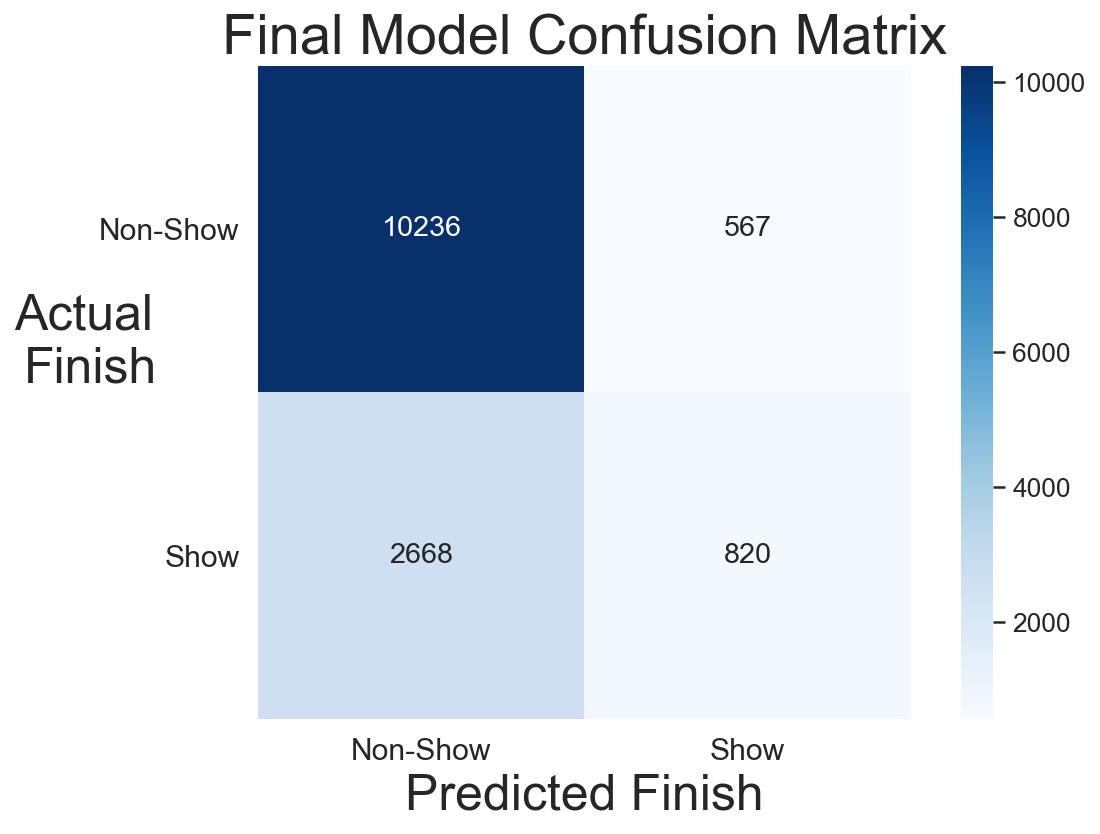

In [382]:
sns.heatmap(cm, cmap=plt.cm.Blues, annot=True, square=True, fmt='d',
           xticklabels=['Non-Show', 'Show'],
           yticklabels=['Non-Show', 'Show'])

plt.xlabel('Predicted Finish', size=25)
plt.ylabel('Actual \nFinish', rotation=0, size=25)
plt.xticks(rotation=0, size=15)
plt.yticks(rotation=0, size=15)
plt.title('Final Model Confusion Matrix', size = 28);

### Feature Importance:

In [223]:
weight_features = xgb_model.get_booster().get_score(importance_type = 'weight')
weight_features

{'place_odds': 49,
 'place_odds * three_race_rolling_average_distance_per_time': 96,
 'actual_weight * place_odds': 104,
 'place_odds + three_race_rolling_average_distance_per_time': 37,
 'horse_rating * place_odds': 50,
 'place_odds + three_race_avg_mid_time': 79,
 'three_race_rolling_average_lengths': 29,
 'career_show_rate': 21,
 'three_race_rolling_average_distance_per_time': 25,
 'horse_rating': 16,
 'diff_from_field_rating_avg': 23,
 'three_race_avg_mid_len_gain': 19,
 'career_races': 19,
 'three_race_rolling_average_len_len1': 46,
 'three_race_rolling_average_time': 22,
 'draw': 16,
 'float_days_since_last_race': 25,
 'diff_from_field_declared_wgt_avg': 27,
 'diff_from_field_handicap_wgt_avg': 22,
 'field_dec_wgt_rank': 8,
 'actual_weight': 10,
 'three_race_rolling_avg_finish': 17,
 'field_age_rank': 5,
 'top_10_trainer': 4,
 'shows_in_last_5_races': 5,
 'three_race_avg_mid_time': 33,
 'diff_from_field_age_avg': 20,
 'AUS': 7,
 'IRE': 1,
 'horses_in_field': 9,
 'horse_age': 5,
 

SOrting by weight DESC:

In [224]:
sorted_weight = sorted(weight_features.items(), key=operator.itemgetter(1), reverse=True)

In [225]:
sorted_weight

[('actual_weight * place_odds', 104),
 ('place_odds * three_race_rolling_average_distance_per_time', 96),
 ('place_odds + three_race_avg_mid_time', 79),
 ('horse_rating * place_odds', 50),
 ('place_odds', 49),
 ('three_race_rolling_average_len_len1', 46),
 ('place_odds + three_race_rolling_average_distance_per_time', 37),
 ('three_race_avg_mid_time', 33),
 ('three_race_rolling_average_lengths', 29),
 ('diff_from_field_declared_wgt_avg', 27),
 ('three_race_rolling_average_distance_per_time', 25),
 ('float_days_since_last_race', 25),
 ('diff_from_field_rating_avg', 23),
 ('three_race_rolling_average_time', 22),
 ('diff_from_field_handicap_wgt_avg', 22),
 ('career_show_rate', 21),
 ('diff_from_field_age_avg', 20),
 ('three_race_avg_mid_len_gain', 19),
 ('career_races', 19),
 ('three_race_rolling_avg_finish', 17),
 ('horse_rating', 16),
 ('draw', 16),
 ('declared_weight', 12),
 ('actual_weight', 10),
 ('horses_in_field', 9),
 ('field_dec_wgt_rank', 8),
 ('career_shows', 8),
 ('AUS', 7),
 (

Features by gain:

In [226]:
gain_features = xgb_model.get_booster().get_score(importance_type = 'gain')
gain_features

{'place_odds': 171.93164090714285,
 'place_odds * three_race_rolling_average_distance_per_time': 103.15879591093751,
 'actual_weight * place_odds': 132.81760980930767,
 'place_odds + three_race_rolling_average_distance_per_time': 88.00420212756755,
 'horse_rating * place_odds': 59.98751042660003,
 'place_odds + three_race_avg_mid_time': 32.45437466329114,
 'three_race_rolling_average_lengths': 24.74527283,
 'career_show_rate': 13.431900210952382,
 'three_race_rolling_average_distance_per_time': 10.632680378399996,
 'horse_rating': 9.675705705625,
 'diff_from_field_rating_avg': 9.042132042173915,
 'three_race_avg_mid_len_gain': 7.802863952105263,
 'career_races': 7.156407482631581,
 'three_race_rolling_average_len_len1': 9.342640992608697,
 'three_race_rolling_average_time': 7.526596370454545,
 'draw': 6.0629632468125,
 'float_days_since_last_race': 9.471972943399999,
 'diff_from_field_declared_wgt_avg': 6.863525741481482,
 'diff_from_field_handicap_wgt_avg': 8.064386949090908,
 'field_

In [227]:
sorted_gain = sorted(gain_features.items(), key=operator.itemgetter(1), reverse=True)
sorted_gain

[('place_odds', 171.93164090714285),
 ('actual_weight * place_odds', 132.81760980930767),
 ('place_odds * three_race_rolling_average_distance_per_time',
  103.15879591093751),
 ('place_odds + three_race_rolling_average_distance_per_time',
  88.00420212756755),
 ('horse_rating * place_odds', 59.98751042660003),
 ('place_odds + three_race_avg_mid_time', 32.45437466329114),
 ('three_race_rolling_average_lengths', 24.74527283),
 ('top_10_jockey', 13.6269798),
 ('career_show_rate', 13.431900210952382),
 ('top_10_trainer', 11.98901285),
 ('three_race_rolling_average_distance_per_time', 10.632680378399996),
 ('horse_age', 10.40104541),
 ('horse_rating', 9.675705705625),
 ('career_shows', 9.477356371250002),
 ('float_days_since_last_race', 9.471972943399999),
 ('three_race_rolling_average_len_len1', 9.342640992608697),
 ('diff_from_field_rating_avg', 9.042132042173915),
 ('AUS', 8.681487695714287),
 ('horses_in_field', 8.402756903333335),
 ('field_handicap_wgt_rank', 8.278007333333333),
 ('dif

## Visualization

Below is some visualization on the final model, on the test set:

In [471]:
y_pred_2 = xgb_model.predict_proba(X_test)[:,1]

In [476]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_2)

In [477]:
precision_curve, recall_curve, threshold_curve = precision_recall_curve(y_test, y_pred_2)

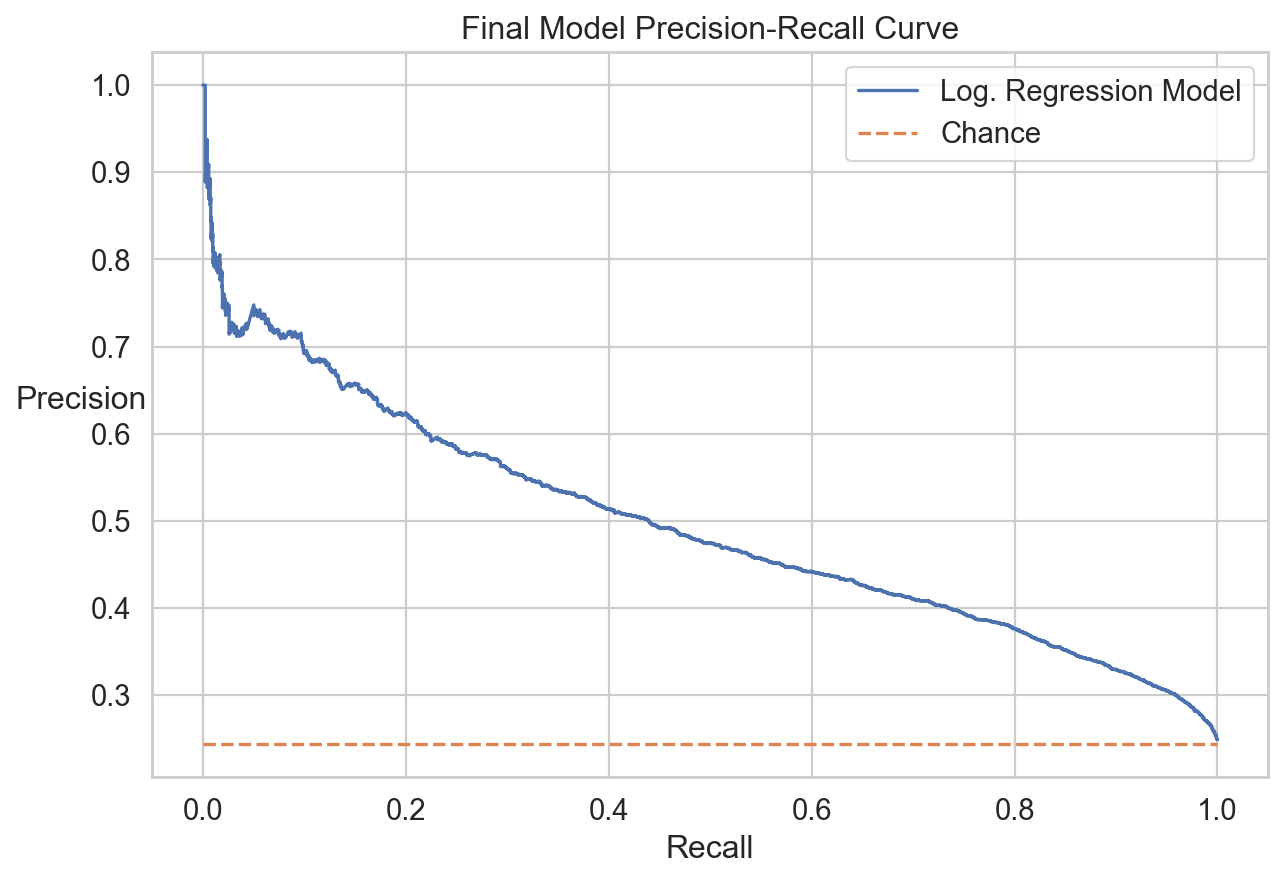

In [478]:
plt.figure(dpi=80)
no_skill = len(y_test[y_test==1]) / len(y_test)
plt.plot(recall_curve, precision_curve,label='Log. Regression Model')
plt.plot([0,1], [no_skill, no_skill], linestyle = '--', label = 'Chance')
plt.xlabel("Recall", rotation=0)
plt.ylabel("Precision", rotation=0)
plt.legend()
plt.title("Final Model Precision-Recall Curve");

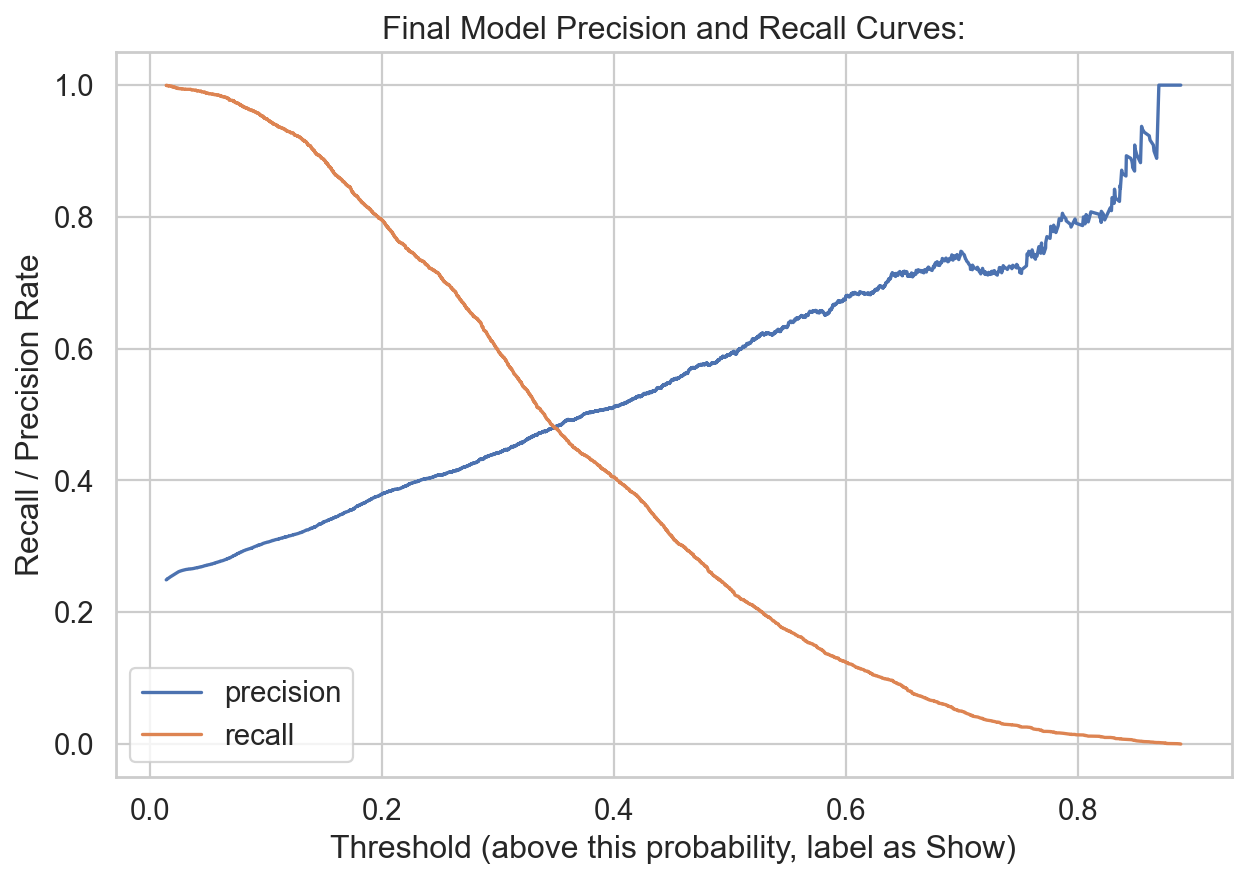

In [483]:
plt.figure(dpi=80)
plt.plot(threshold_curve, precision_curve[1:],label='precision')
plt.plot(threshold_curve, recall_curve[1:], label='recall')
plt.legend(loc='lower left')
plt.xlabel('Threshold (above this probability, label as Show)');
plt.ylabel('Recall / Precision Rate')
plt.title('Final Model Precision and Recall Curves:');


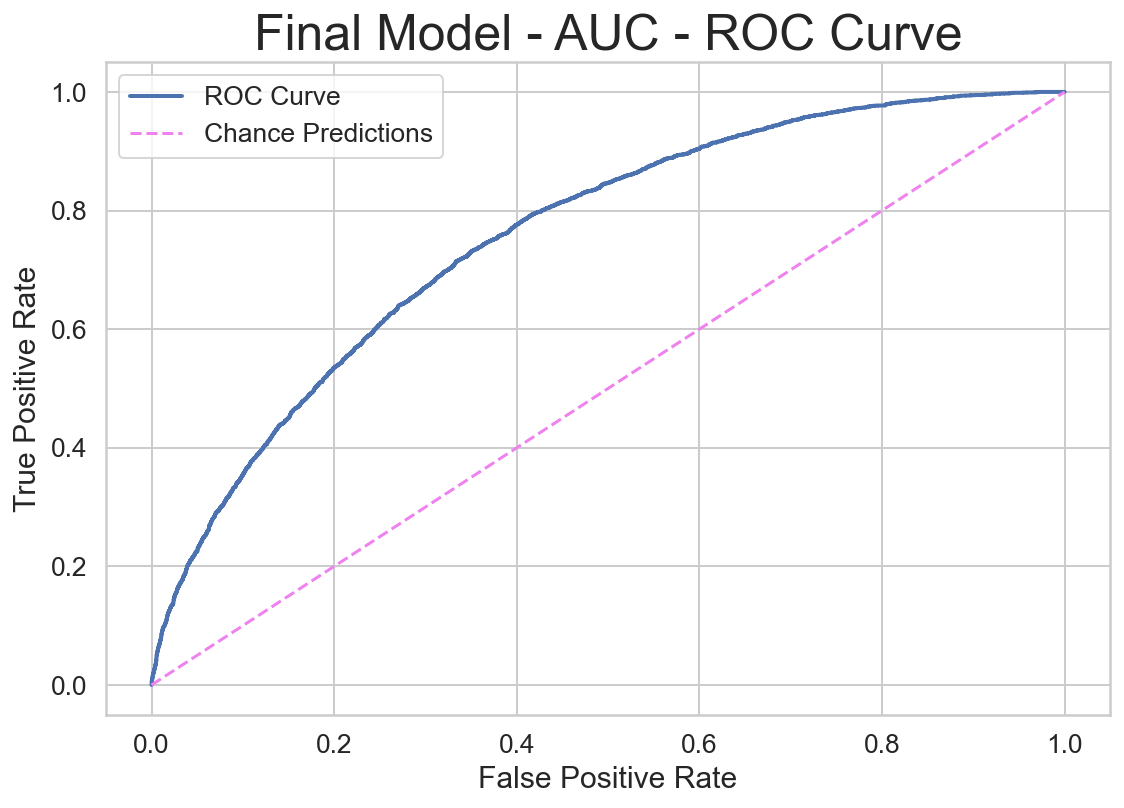

In [485]:
plt.plot(fpr, tpr,lw=2, label = 'ROC Curve')
plt.plot([0,1],[0,1],c='violet',ls='--', label = 'Chance Predictions')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])
plt.title('Final Model - AUC - ROC Curve', size=25)
plt.xlabel('False Positive Rate', size=15)
plt.ylabel('True Positive Rate', size=15)
plt.legend()

## Model Error Analysis:

In [196]:
X_resid = test_horses_final_cleaned[columns_int]

In [199]:
test_horses_final_cleaned['prediction'] = xgb_model.predict(X_resid)

In [204]:
test_horses_final_cleaned['probability'] = xgb_model.predict_proba(X_resid)[:,1]

In [205]:
test_horses_final_cleaned.head()

race_id  horse_id  result  lengths_behind  horse_age horse_country  \
2844     6120      3960       2            4.00          7           IRE   
2845     6120      2381       3            5.50          3           AUS   
2846     6120       896       4            6.50          5           AUS   
2847     6120      3635       5            6.75          4            NZ   
2848     6120      4089       6            7.25          5           AUS   

      horse_rating horse_gear  declared_weight  actual_weight  ...  GB  USA  \
2844            43         --            975.0            117  ...   0    0   
2845            47         TT           1199.0            119  ...   0    0   
2846            59         B2           1082.0            126  ...   0    0   
2847            45        TT2           1129.0            119  ...   0    0   
2848            57       TT/H           1149.0            131  ...   0    0   

      Other  actual_weight * place_odds  \
2844      0                       304.2   
2845      0                       999.6   
2846      0                       819.0   
2847      0                       202.3   
2848      0                       248.9   

      place_odds * three_race_rolling_average_distance_per_time  \
2844                                          43.897403           
2845                                         143.627645           
2846                                         109.613961           
2847                                          27.874342           
2848                                          30.684777           

      horse_rating * place_odds  place_odds + three_race_avg_mid_time  \
2844                      111.8                              3.470000   
2845                      394.8                              9.463333   
2846                      383.5                              7.690000   
2847                       76.5                              2.560000   
2848                      108.3                              2.753333   

      place_odds + three_race_rolling_average_distance_per_time  prediction  \
2844                                          19.483616                   0   
2845                                          25.498529                   0   
2846                                          23.363686                   0   
2847                                          18.096672                   0   
2848                                          18.049883                   0   

      probability  
2844     0.322063  
2845     0.099455  
2846     0.118271  
2847     0.493658  
2848     0.401408  

[5 rows x 93 columns]

There are 2 challenge cases to check: 
1. Horse Predicted to show, didn't (false positive)
2. Horse Predicted to not show, did (false negative)

### Challenge 1: False Positive:

In [206]:
bad_preds = test_horses_final_cleaned[(test_horses_final_cleaned.prediction == 1) & (test_horses_final_cleaned.show == 0)].sort_values(by=['probability'], ascending=False)

In [208]:
bad_preds.head(20)

race_id  horse_id  result  lengths_behind  horse_age horse_country  \
18787     4849      4089       4            1.50          3           AUS   
12906     5316      2586       5            3.25          2           AUS   
52563     2149       368       8            8.50          3           AUS   
46737     2610      2621       4            1.75          3            NZ   
74079      426       427       4            1.50          3           AUS   
52559     2149      3275       4            5.75          3           AUS   
16576     5025      3192       4            0.75          4            NZ   
34529     3585      2087       5            2.75          3            NZ   
26887     4198      1135       5            5.25          3            GB   
13126     5299       419      10            6.25          3            NZ   
31823     3802      3006       4            1.75          3           AUS   
54574     1983      3037       5            1.75          3           AUS   
35694     3491      1741       6            1.50          3           AUS   
50021     2352      2523       4            1.50          3            NZ   
20096     4745       628       4            0.25          3            NZ   
72818      528      3051       5            4.00          3           AUS   
58213     1694       640       8            7.25          3            NZ   
45404     2718      3046      10            8.75          3            GB   
40711     3095      2036       4            3.00          3           AUS   
18007     4912      2921       8            3.00          5           USA   

       horse_rating horse_gear  declared_weight  actual_weight  ...  GB  USA  \
18787            60       TT/H           1162.0            133  ...   0    0   
12906            64          B           1062.0            121  ...   0    0   
52563            60         --           1122.0            128  ...   0    0   
46737            66         --           1035.0            122  ...   0    0   
74079            60         --           1084.0            129  ...   0    0   
52559            60         --           1183.0            123  ...   0    0   
16576            32          P           1087.0            125  ...   0    0   
34529            60         --           1196.0            124  ...   0    0   
26887            60         --           1207.0            126  ...   1    0   
13126            74          H           1127.0            128  ...   0    0   
31823            60         --           1009.0            130  ...   0    0   
54574            60         --           1131.0            131  ...   0    0   
35694            60         --           1242.0            120  ...   0    0   
50021            67         CP           1143.0            121  ...   0    0   
20096            61          B           1104.0            116  ...   0    0   
72818            60         --           1035.0            130  ...   0    0   
58213            60         --           1128.0            127  ...   0    0   
45404            60         --           1164.0            133  ...   1    0   
40711            60         --           1017.0            130  ...   0    0   
18007            37          B           1069.0            130  ...   0    1   

       Other  actual_weight * place_odds  \
18787      0                       133.0   
12906      0                       121.0   
52563      0                       128.0   
46737      0                       122.0   
74079      0                       129.0   
52559      0                       123.0   
16576      0                       125.0   
34529      0                       136.4   
26887      0                       126.0   
13126      0                       128.0   
31823      0                       143.0   
54574      0                       131.0   
35694      0                       132.0   
50021      0                       133.1   
20096      0                       127.6   
7281

I am going to check out some of the races for the extremes on these, to see how the race field performed:

In [218]:
test_horses_final_cleaned[['race_id', 'horse_id', 'distance', 'lengths_behind', 'finish_time', 'place_odds', 'result','prediction', 'probability', 'career_races', 'career_shows']][test_horses_final_cleaned.race_id==4849].sort_values(by='result')

race_id  horse_id  distance  lengths_behind  finish_time  place_odds  \
18784     4849      1233      1200            0.00        70.45         3.7   
18785     4849       312      1200            0.20        70.48         1.5   
18786     4849      3665      1200            0.50        70.55         2.2   
18787     4849      4089      1200            1.50        70.71         1.0   
18788     4849       653      1200            2.00        70.78         2.6   
18789     4849       314      1200            2.75        70.90        12.0   
18791     4849      1654      1200            3.25        70.98        25.0   
18792     4849       607      1200            4.00        71.09         3.4   
18794     4849      3142      1200            4.75        71.19        43.0   

       result  prediction  probability  career_races  career_shows  
18784       1           0     0.249618             6           2.0  
18785       2           1     0.558048             2           1.0  
18786       3           0     0.344577            52          17.0  
18787       4           1     0.869331             2           2.0  
18788       5           0     0.295169            21          11.0  
18789       6           0     0.065173             3           1.0  
18791       8           0     0.020322            47           7.0  
18792       9           0     0.246409             2           0.0  
18794      11           0     0.013176             2           0.0

In [219]:
test_horses_final_cleaned[['race_id', 'horse_id', 'distance', 'lengths_behind', 'finish_time', 'place_odds', 'result','prediction', 'probability', 'career_races', 'career_shows']][test_horses_final_cleaned.race_id==5316].sort_values(by='result')

race_id  horse_id  distance  lengths_behind  finish_time  place_odds  \
12902     5316      2879      1200            0.00        69.23         3.2   
12903     5316       936      1200            0.25        69.27         2.1   
12905     5316      3665      1200            2.25        69.60         4.6   
12906     5316      2586      1200            3.25        69.76         1.0   
12907     5316      4268      1200            3.50        69.77        34.0   
12908     5316       602      1200            4.25        69.91         7.0   
12909     5316      4126      1200            4.25        69.92         2.7   
12910     5316      3757      1200            4.75        69.98        11.0   
12911     5316       698      1200            5.25        70.05         7.1   
12912     5316      1914      1200            5.50        70.11        43.0   
12914     5316      1150      1200            8.50        70.60         2.7   

       result  prediction  probability  career_races  career_shows  
12902       1           0     0.236799             1           0.0  
12903       2           0     0.358042            11           3.0  
12905       4           0     0.171871            63          22.0  
12906       5           1     0.854436             1           1.0  
12907       6           0     0.011670             1           0.0  
12908       7           0     0.136437            16           9.0  
12909       8           0     0.315560             8           2.0  
12910       9           0     0.086803            13           0.0  
12911      10           0     0.115200            19           7.0  
12912      11           0     0.012197             7           0.0  
12914      13           0     0.312128             2           0.0

In [220]:
test_horses_final_cleaned[['race_id', 'horse_id', 'distance', 'lengths_behind', 'finish_time', 'place_odds', 'result','prediction', 'probability', 'career_races', 'career_shows']][test_horses_final_cleaned.race_id==2149].sort_values(by='result')

race_id  horse_id  distance  lengths_behind  finish_time  place_odds  \
52559     2149      3275      1200            5.75        70.53         1.0   
52560     2149       495      1200            5.75        70.53        11.0   
52561     2149      3594      1200            6.75        70.70        16.0   
52562     2149      2807      1200            7.00        70.74         8.1   
52563     2149       368      1200            8.50        70.97         1.0   
52565     2149      4213      1200            9.25        71.11        16.0   
52566     2149      1215      1200            9.25        71.11        17.0   
52568     2149      3531      1200           13.00        71.72        29.0   

       result  prediction  probability  career_races  career_shows  
52559       4           1     0.836097             1           1.0  
52560       5           0     0.073662            16           5.0  
52561       6           0     0.049378             1           0.0  
52562       7           0     0.111654             9           2.0  
52563       8           1     0.848513             2           2.0  
52565      10           0     0.045458             2           0.0  
52566      11           0     0.044899             2           0.0  
52568      13           0     0.017942             1           0.0

In [221]:
test_horses_final_cleaned[['race_id', 'horse_id', 'distance', 'lengths_behind', 'finish_time', 'place_odds', 'result','prediction', 'probability', 'career_races', 'career_shows']][test_horses_final_cleaned.race_id==2610].sort_values(by='result')

race_id  horse_id  distance  lengths_behind  finish_time  place_odds  \
46734     2610       804      1400            0.00        83.09         4.1   
46735     2610      2226      1400            0.75        83.21         2.4   
46736     2610      2926      1400            0.75        83.23         2.5   
46737     2610      2621      1400            1.75        83.39         1.0   
46738     2610      3886      1400            2.25        83.45         1.2   
46739     2610      3657      1400            3.00        83.58         6.2   
46740     2610      1417      1400            4.00        83.73         2.7   
46741     2610       666      1400            5.75        84.01         7.4   
46743     2610       116      1400            8.00        84.35        17.0   

       result  prediction  probability  career_races  career_shows  
46734       1           0     0.196841            50          15.0  
46735       2           0     0.337475             1           1.0  
46736       3           0     0.319790            36           7.0  
46737       4           1     0.841320             1           1.0  
46738       5           1     0.690718            17          10.0  
46739       6           0     0.158470            28          12.0  
46740       7           0     0.265927            53          20.0  
46741       8           0     0.113505            27           5.0  
46743      10           0     0.040466             2           0.0

In [222]:
test_horses_final_cleaned[['race_id', 'horse_id', 'distance', 'lengths_behind', 'finish_time', 'place_odds', 'result','prediction', 'probability', 'career_races', 'career_shows']][test_horses_final_cleaned.race_id==426].sort_values(by='result')

race_id  horse_id  distance  lengths_behind  finish_time  place_odds  \
74076      426      1984      1400            0.00        83.61         1.2   
74077      426       230      1400            0.50        83.71         5.0   
74078      426      1418      1400            0.75        83.75         5.8   
74079      426       427      1400            1.50        83.85         1.0   
74080      426       552      1400            3.50        84.16         2.0   
74081      426      1198      1400            5.00        84.42         4.8   
74082      426      2650      1400            6.00        84.57        14.0   
74084      426      2806      1400           10.25        85.26        29.0   
74085      426      3656      1400           10.50        85.27         3.5   
74086      426      1101      1400           16.00        86.16        20.0   
74087      426       473      1400           20.50        86.89        28.0   

       result  prediction  probability  career_races  career_shows  
74076       1           1     0.687482             3           2.0  
74077       2           0     0.174581             6           0.0  
74078       3           0     0.145159             2           0.0  
74079       4           1     0.837292             1           1.0  
74080       5           0     0.408587             7           5.0  
74081       6           0     0.187969             9           5.0  
74082       7           0     0.055183            10           1.0  
74084       9           0     0.021550             2           0.0  
74085      10           0     0.233578             7           2.0  
74086      11           0     0.021166             1           0.0  
74087      12           0     0.016476             2           0.0

Overall, in this case (false positives), the model appears to struggle on shorter distances (i..e not much time between third and fourth) and horses with less career races.

### Challenge Case 2:  Horse Predicted not to show, does (false negative):

In [228]:
no_preds = test_horses_final_cleaned[(test_horses_final_cleaned.prediction == 0) & (test_horses_final_cleaned.show == 1)].sort_values(by=['probability'], ascending=True)

In [229]:
no_preds.head(20)

race_id  horse_id  result  lengths_behind  horse_age horse_country  \
3990      6028       127       2            1.75          3           IRE   
78849       41       134       3            0.75          3           AUS   
74324      405      4112       2            2.00          3           AUS   
36560     3422      1925       3            3.25          3            GB   
22490     4550      3875       3            3.25          4           AUS   
54534     1986      1106       3            1.75          3           AUS   
51460     2237      2790       3            3.25          3            NZ   
67220      974      2338       3            3.00          3           USA   
30295     3924      4191       3            3.25          3            NZ   
22584     4543      1741       3            2.50          3           AUS   
76169      255      1110       2            1.25          3            NZ   
77359      160      3420       3            2.00          3            GB   
28170     4095      1615       2            2.50          3            NZ   
20944     4678        19       3            2.00          3           AUS   
41780     3006      3252       3            0.25          3           AUS   
30745     3889      2709       2            0.50          3            GB   
31390     3837      1445       3            4.75          3            FR   
12823     5322      3313       3            1.75          5            NZ   
40237     3134       979       3            2.75          3           AUS   
5346      5920      3509       3            1.50          4           AUS   

       horse_rating horse_gear  declared_weight  actual_weight  ...  GB  USA  \
3990             80     TT/CP-           1133.0            133  ...   0    0   
78849            60         --           1096.0            115  ...   0    0   
74324            60         --           1089.0            128  ...   0    0   
36560            86   TT/H-/XB           1015.0            121  ...   1    0   
22490            44     TT-/B-           1137.0            116  ...   0    0   
54534            60         --           1069.0            126  ...   0    0   
51460            60         --           1102.0            114  ...   0    0   
67220            60         --           1095.0            121  ...   0    1   
30295            60         --           1085.0            123  ...   0    0   
22584            60         --           1263.0            117  ...   0    0   
76169            60         --           1130.0            116  ...   0    0   
77359            60         --            974.0            113  ...   1    0   
28170            50      TT/H-           1105.0            122  ...   0    0   
20944            52      TT/SR           1119.0            127  ...   0    0   
41780            60         --           1183.0            126  ...   0    0   
30745            61         H1           1099.0            113  ...   1    0   
31390            60         --           1046.0            110  ...   0    0   
12823            61       TT/H           1004.0            113  ...   0    0   
40237            60         --           1160.0            114  ...   0    0   
5346            103       TT/B           1189.0            126  ...   0    0   

       Other  actual_weight * place_odds  \
3990       0                      3591.0   
78849      0                      3105.0   
74324      0                      4096.0   
36560      0                      4719.0   
22490      0                      3248.0   
54534      0                      2646.0   
51460      0                      3648.0   
67220      0                      2783.0   
30295      0                      3813.0   
22584      0                      2925.0   
76169      0                      2552.0   
77359      0                      3390.0   
28170      0                      2684.0   
20944      0                      2540.0   
41780      0                      2520.0   
3074

I am going to check out some of the races for the extremes on these, to see how the race field performed:

In [230]:
test_horses_final_cleaned[['race_id', 'horse_id', 'distance', 'lengths_behind', 'finish_time', 'place_odds', 'result','prediction', 'probability', 'career_races', 'career_shows']][test_horses_final_cleaned.race_id==6028].sort_values(by='result')

race_id  horse_id  distance  lengths_behind  finish_time  place_odds  \
3989     6028      4266      1200            0.00        69.44         1.5   
3990     6028       127      1200            1.75        69.74        27.0   
3992     6028       813      1200            4.00        70.06         4.7   
3993     6028      3536      1200            4.00        70.07         1.3   
3994     6028      2143      1200            5.00        70.23         2.4   
3995     6028      4036      1200            6.00        70.39         2.3   
3996     6028      1954      1200            6.50        70.46         2.9   
3997     6028      2104      1200           10.25        71.08         2.9   
3998     6028       605      1200           11.50        71.28         7.3   
3999     6028      1857      1200           15.00        71.83        34.0   

      result  prediction  probability  career_races  career_shows  
3989       1           1     0.597466             7           3.0  
3990       2           0     0.014077             2           0.0  
3992       4           0     0.170392            46          13.0  
3993       5           1     0.651893             6           6.0  
3994       6           0     0.350146            17           6.0  
3995       7           0     0.317848             4           0.0  
3996       8           0     0.309885            13           4.0  
3997       9           0     0.293014             6           3.0  
3998      10           0     0.112871            35          16.0  
3999      11           0     0.012903            24           8.0

In [231]:
test_horses_final_cleaned[['race_id', 'horse_id', 'distance', 'lengths_behind', 'finish_time', 'place_odds', 'result','prediction', 'probability', 'career_races', 'career_shows']][test_horses_final_cleaned.race_id==41].sort_values(by='result')

race_id  horse_id  distance  lengths_behind  finish_time  place_odds  \
78847       41      4347      1600            0.00        95.28         1.8   
78848       41      3499      1600            0.50        95.37         5.9   
78849       41       134      1600            0.75        95.43        27.0   
78850       41      4349      1600            1.25        95.50         3.7   
78851       41      2800      1600            2.00        95.60         4.2   
78852       41      2199      1600            2.25        95.66         6.0   
78853       41      3301      1600            3.00        95.75         1.2   
78854       41      2966      1600            3.25        95.82         1.4   
78856       41      1069      1600            4.50        96.01         5.9   
78857       41      1032      1600            5.25        96.11        21.0   
78858       41      1875      1600            8.75        96.69        30.0   
78859       41      2797      1600           10.00        96.88        31.0   

       result  prediction  probability  career_races  career_shows  
78847       1           0     0.492301             1           1.0  
78848       2           0     0.123920             1           0.0  
78849       3           0     0.014606             1           0.0  
78850       4           0     0.259321             1           0.0  
78851       5           0     0.223648             1           0.0  
78852       6           0     0.163430             1           0.0  
78853       7           1     0.692953             1           0.0  
78854       8           1     0.636504             1           1.0  
78856      10           0     0.155120             1           0.0  
78857      11           0     0.028260             1           0.0  
78858      12           0     0.013188             1           0.0  
78859      13           0     0.017473             1           0.0

In [232]:
test_horses_final_cleaned[['race_id', 'horse_id', 'distance', 'lengths_behind', 'finish_time', 'place_odds', 'result','prediction', 'probability', 'career_races', 'career_shows']][test_horses_final_cleaned.race_id==405].sort_values(by='result')

race_id  horse_id  distance  lengths_behind  finish_time  place_odds  \
74323      405       149      1600            0.00        96.71         1.3   
74324      405      4112      1600            2.00        97.03        32.0   
74325      405      1733      1600            3.00        97.21         2.1   
74326      405      3345      1600            3.25        97.22        12.0   
74327      405      4043      1600            3.50        97.26         1.8   
74328      405      2792      1600            3.50        97.27         4.8   
74329      405       557      1600            9.75        98.25         2.7   
74330      405      1497      1600           13.00        98.79        26.0   
74331      405      3619      1600           19.00        99.76         1.4   
74332      405      3985      1600           20.00        99.90        20.0   

       result  prediction  probability  career_races  career_shows  
74323       1           1     0.628991             5           3.0  
74324       2           0     0.014839             7           2.0  
74325       3           0     0.378947             5           4.0  
74326       4           0     0.078010             3           0.0  
74327       5           0     0.420832             6           0.0  
74328       6           0     0.182858             9           1.0  
74329       7           0     0.311124             5           0.0  
74330       8           0     0.019162             3           0.0  
74331       9           1     0.565337             4           1.0  
74332      10           0     0.023961             4           0.0

In [233]:
test_horses_final_cleaned[['race_id', 'horse_id', 'distance', 'lengths_behind', 'finish_time', 'place_odds', 'result','prediction', 'probability', 'career_races', 'career_shows']][test_horses_final_cleaned.race_id==3422].sort_values(by='result')

race_id  horse_id  distance  lengths_behind  finish_time  place_odds  \
36558     3422      2544      1400            0.00        81.31         2.0   
36559     3422      1492      1400            1.00        81.47         1.5   
36560     3422      1925      1400            3.25        81.82        39.0   
36561     3422       154      1400            3.25        81.82         1.6   
36562     3422       781      1400            4.25        81.98         4.9   
36563     3422      1598      1400            6.25        82.30         2.7   
36564     3422      4265      1400            7.25        82.48         8.7   
36566     3422      1678      1400            8.50        82.66         2.4   
36567     3422      2741      1400            8.75        82.71         2.4   
36568     3422       241      1400            9.50        82.83        23.0   
36569     3422      3065      1400           10.50        82.98         8.7   
36570     3422      3067      1400           11.25        83.09        35.0   
36571     3422       406      1400           13.75        83.50        42.0   

       result  prediction  probability  career_races  career_shows  
36558       1           0     0.447265             7           3.0  
36559       2           1     0.556570             8           6.0  
36560       3           0     0.016151             1           0.0  
36561       4           1     0.501191             8           6.0  
36562       5           0     0.148949             4           0.0  
36563       6           0     0.343706            14           9.0  
36564       7           0     0.089855            46          10.0  
36566       9           0     0.366524            12           8.0  
36567      10           0     0.348876            13           7.0  
36568      11           0     0.024065            47          18.0  
36569      12           0     0.092946             2           0.0  
36570      13           0     0.015522             2           0.0  
36571      14           0     0.012237             2           0.0

In [234]:
test_horses_final_cleaned[['race_id', 'horse_id', 'distance', 'lengths_behind', 'finish_time', 'place_odds', 'result','prediction', 'probability', 'career_races', 'career_shows']][test_horses_final_cleaned.race_id==4550].sort_values(by='result')

race_id  horse_id  distance  lengths_behind  finish_time  place_odds  \
22488     4550       925      1200            0.00        69.26         2.8   
22489     4550      1702      1200            3.00        69.74         1.4   
22490     4550      3875      1200            3.25        69.80        28.0   
22491     4550      1034      1200            4.25        69.96         7.3   
22492     4550      3960      1200            4.75        70.01         3.2   
22493     4550       879      1200            5.25        70.09         2.1   
22494     4550       605      1200            6.00        70.21         1.9   
22495     4550      2917      1200            6.00        70.23         2.7   
22496     4550      2865      1200            6.00        70.23        25.0   
22497     4550      2622      1200            6.75        70.32         6.4   
22498     4550       449      1200            7.00        70.37        16.0   
22499     4550      1845      1200            8.50        70.64         5.3   
22500     4550       998      1200           16.25        71.85        50.0   
22501     4550      1088      1200           20.00        72.44         3.7   

       result  prediction  probability  career_races  career_shows  
22488       1           0     0.287940             1           0.0  
22489       2           1     0.555700             8           3.0  
22490       3           0     0.016759            11           0.0  
22491       4           0     0.115346             8           0.0  
22492       5           0     0.323746            29           7.0  
22493       6           0     0.320376            25          10.0  
22494       7           0     0.438955            13           5.0  
22495       8           0     0.342721            31           5.0  
22496       9           0     0.023170             6           0.0  
22497      10           0     0.152519            40          13.0  
22498      11           0     0.044509            14           3.0  
22499      12           0     0.153231            12           0.0  
22500      13           0     0.012066             8           0.0  
22501      14           0     0.226495            23           4.0

This also looks like it tends to be fields with less clear cut favorites.  However, time still plays a factor - sometimes, very small difference between in 3rd and 4th+ (i.e. small separability).

Additionally, many of these horses that showed with low probability were long underdogs, with less amounts of career races - hard for the model to predict.

## Comparing Differences:

Horses w/ correct predictions (yes or no):

In [249]:
correct_preds = test_horses_final_cleaned[(test_horses_final_cleaned.prediction == test_horses_final_cleaned.show)].sort_values(by=['probability'], ascending=True)

### Race Distances:

Correct Predictions:

In [251]:
correct_preds.distance.value_counts()

1200    3464
1400    2074
1650    1794
1600    1164
1800    1075
1000    1019
2000     261
2200     182
2400      23
Name: distance, dtype: int64

In [384]:
from matplotlib import cm
from colorspacious import cspace_converter
from collections import OrderedDict

ModuleNotFoundError: No module named 'colorspacious'

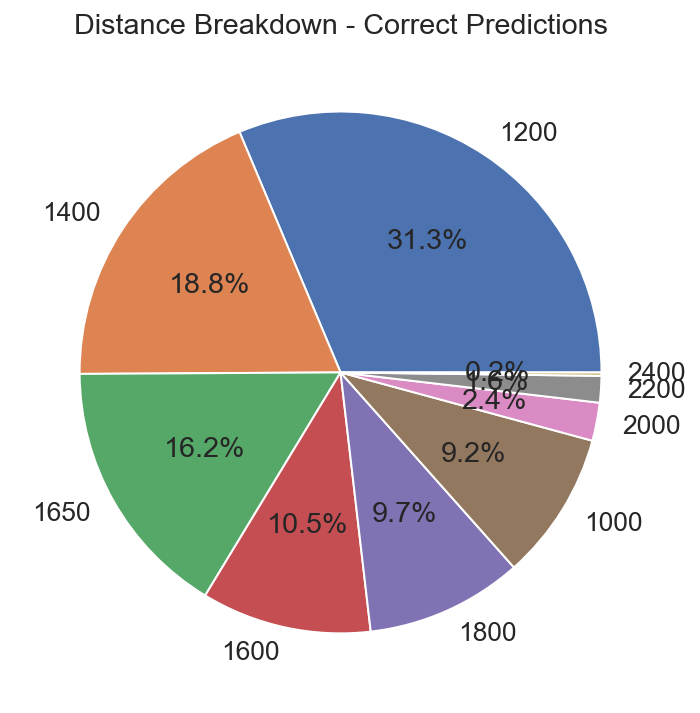

In [252]:
whole_set = list(correct_preds.distance.value_counts())
labels = ['1200', '1400', '1650', '1600', '1800', '1000', '2000', '2200', '2400']
plt.pie(whole_set, labels = labels, autopct='%1.1f%%')
plt.title('Distance Breakdown - Correct Predictions');

False Positives:

In [253]:
bad_preds.distance.value_counts()

1200    215
1400    109
1650     73
1000     61
1600     56
1800     33
2000     12
2200      7
2400      1
Name: distance, dtype: int64

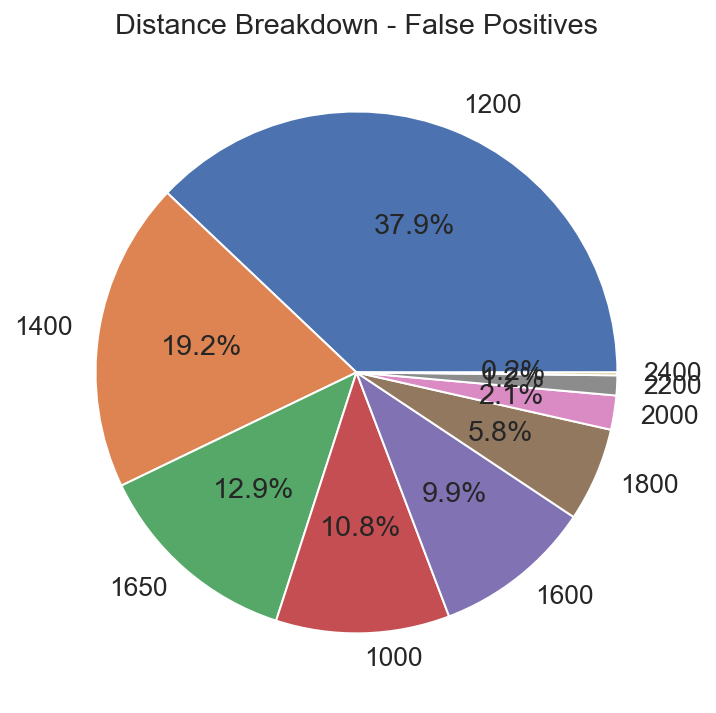

In [256]:
fp_set = list(bad_preds.distance.value_counts())
labels = ['1200', '1400', '1650', '1000', '1600', '1800', '2000', '2200', '2400']
plt.pie(fp_set, labels = labels, autopct='%1.1f%%')
plt.title('Distance Breakdown - False Positives');

False Negatives:

In [257]:
no_preds.distance.value_counts()

1200    804
1650    499
1400    467
1800    270
1600    255
1000    248
2000     63
2200     57
2400      5
Name: distance, dtype: int64

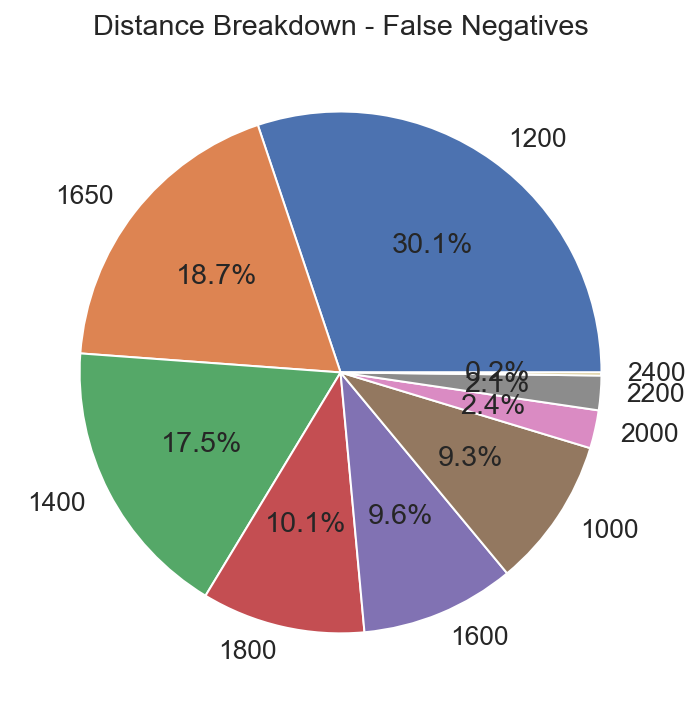

In [258]:
fn_set = list(no_preds.distance.value_counts())
labels = ['1200', '1650', '1400', '1800', '1600', '1000', '2000', '2200', '2400']
plt.pie(fn_set, labels = labels, autopct='%1.1f%%')
plt.title('Distance Breakdown - False Negatives');

## Random Race Card:

Viewing some results from some races in the test set:

In [427]:
test_horses_final_cleaned[test_horses_final_cleaned.probability < .80].tail(50)

race_id  horse_id  result  lengths_behind  horse_age horse_country  \
78596       63      3844      12            7.25          3            NZ   
78620       60      3119       1            0.00          3           IRE   
78621       60      3487       2            0.10          3           IRE   
78622       60      1677       3            0.75          3            NZ   
78623       60      4317       4            2.25          3           AUS   
78625       60      1198       6            4.25          3            NZ   
78628       60      3125       9            6.75          3           AUS   
78630       60      4374      11            9.75          3           AUS   
78631       60      2641      12           13.50          3           USA   
78699       53      1517       3            0.75          3           IRE   
78700       53      2200       4            2.00          3            NZ   
78702       53      1402       6            2.75          3           AUS   
78703       53       939       7            3.25          3            NZ   
78706       53      4037      10            4.75          3            NZ   
78708       53      2973      12            6.75          3           AUS   
78709       53      1398      13            8.00          3           AUS   
78722       51      3446       1            0.00          3           AUS   
78724       51      3842       3            0.50          3           AUS   
78726       51      3905       5            2.50          3           AUS   
78728       51       258       7            3.00          3            NZ   
78729       51      3691       8            3.50          3           IRE   
78732       51       377      11            4.50          3           AUS   
78847       41      4347       1            0.00          3            NZ   
78848       41      3499       2            0.50          3           AUS   
78849       41       134       3            0.75          3           AUS   
78850       41      4349       4            1.25          3            NZ   
78851       41      2800       5            2.00          3            NZ   
78852       41      2199       6            2.25          3            NZ   
78853       41      3301       7            3.00          3           AUS   
78854       41      2966       8            3.25          3            NZ   
78856       41      1069      10            4.50          3           IRE   
78857       41      1032      11            5.25          3           IRE   
78858       41      1875      12            8.75          3           AUS   
78859       41      2797      13           10.00          3           IRE   
78860       40      1899       1            0.00          3            NZ   
78863       40      2069       4            1.50          3           AUS   
78864       40      2162       5            3.25          3           AUS   
78865       40      1689       6            4.00          3           AUS   
78867       40      4048       8            6.25          3           USA   
78869       40      2618      10            9.75          3            NZ   
78875       39      2813       3            0.50          3           AUS   
78876       39      2330       4            1.50          3            NZ   
78877       39      4244       5            2.00          3           AUS   
78878       39       882       6            2.25          3           AUS   
78911       36       252       1            0.00          3           AUS   
78913       36      3859       3            1.25          3            NZ   
78916       36       395       6            3.50          3            NZ   
78917       36      1369       7            4.00          3            NZ   
78919       36      2094       9            7.00          3           IRE   
79076       22       905       1            0.00          3           AUS   

       horse_rating horse_gear  declared_weight  actual_weight  ...  USA  \
785

In [ ]:
test_horses_final_cleaned.sample

In [398]:
test_horses_final_cleaned[test_horses_final_cleaned.race_id == 5507].head(20)

race_id  horse_id  result  lengths_behind  horse_age horse_country  \
10526     5507      1565       1            0.00          5           IRE   
10527     5507      2830       2            1.25          4           AUS   
10528     5507      1033       3            1.50          5           AUS   
10529     5507      2651       4            2.50          4           USA   
10530     5507      1879       5            2.50          4            NZ   
10531     5507      4300       6            3.25          5           IRE   
10532     5507      2217       7            5.25          5            GB   
10533     5507      3663       8            6.25          6           IRE   
10534     5507      2085       9            9.00          5           AUS   

       horse_rating horse_gear  declared_weight  actual_weight  ...  USA  \
10526           118         TT           1196.0            123  ...    0   
10527           121          P           1148.0            123  ...    0   
10528           138         CP           1293.0            128  ...    0   
10529           110        CP1           1213.0            123  ...    1   
10530           109         --           1169.0            123  ...    0   
10531           131         --           1089.0            128  ...    0   
10532           118       H/XB           1099.0            123  ...    0   
10533           125      TT/CP           1092.0            128  ...    0   
10534           118       H/XB           1129.0            123  ...    0   

       Other  actual_weight * place_odds  \
10526      0                       393.6   
10527      0                       159.9   
10528      0                       128.0   
10529      0                       258.3   
10530      0                       184.5   
10531      0                       422.4   
10532      0                      1230.0   
10533      0                      1408.0   
10534      0                      2829.0   

       place_odds * three_race_rolling_average_distance_per_time  \
10526                                          54.761903           
10527                                          22.272252           
10528                                          17.131596           
10529                                          35.841036           
10530                                          25.650131           
10531                                          54.412081           
10532                                         170.020245           
10533                                         186.008506           
10534                                         391.328138           

       horse_rating * place_odds  place_odds + three_race_avg_mid_time  \
10526                      377.6                              3.593333   
10527                      157.3                              1.500000   
10528                      138.0                              0.513333   
10529                      231.0                              2.033333   
10530                      163.5                              1.686667   
10531                      432.3                              2.610000   
10532                     1180.0                              9.926667   
10533                     1375.0                             10.886667   
10534                     2714.0                             23.936667   

       place_odds + three_race_rolling_average_distance_per_time  prediction  \
10526                                          20.313095                   0   
10527                                          18.432502                   1   
10528                                          18.131596                   1   
10529                                          19.167160                   0   
10530                                          18.600088                   1   
10531                                          19.788509                   0   
10532                                          27.00

In [441]:
test_horses_final_cleaned[['horse_id', 'draw', 'place_odds', 'prediction', 'probability', 'result']][test_horses_final_cleaned.race_id == 4659].sort_values(by='probability')

horse_id  draw  place_odds  prediction  probability  result
21192      2931    13        24.0           0     0.028447      12
21189       597    10        12.0           0     0.063156       9
21190      2493     7        12.0           0     0.074739      10
21185      4067     6         8.7           0     0.082927       5
21186      4070    14         5.4           0     0.155732       6
21181      1002     2         4.4           0     0.157765       1
21187      1569     4         2.9           0     0.292214       7
21183      4324     8         2.6           0     0.309729       3
21193      3929     1         2.6           0     0.333532      13
21191      1029    12         2.2           0     0.348101      11
21184      2608    11         2.5           0     0.381576       4
21182      1908     5         2.5           0     0.418991       2
21188      1289     3         1.9           0     0.425154       8

In [435]:
test_horses_final_cleaned.sample(10)

race_id  horse_id  result  lengths_behind  horse_age horse_country  \
49026     2431       100      11            6.00          3            NZ   
18596     4864      2576       1            0.00          4            GB   
64354     1200      3497       4            2.50          3           AUS   
71758      614      3789       6            4.25          3            NZ   
16445     5035      1271       3            4.75          6           AUS   
21185     4659      4067       5            2.00          3           AUS   
17094     4985      2347       4            0.75          3           AUS   
57617     1741      3587      12            7.75          3           AUS   
6932      5793      2292      10           10.75          2            NZ   
76695      214      4006      12           15.75          3           USA   

       horse_rating horse_gear  declared_weight  actual_weight  ...  USA  \
49026            60         --           1218.0            132  ...    0   
18596            76         B1           1078.0            130  ...    0   
64354            60         --           1118.0            108  ...    0   
71758            60         --           1106.0            120  ...    0   
16445            76         P2           1140.0            133  ...    0   
21185            60         --           1103.0            122  ...    0   
17094            60         --           1048.0            130  ...    0   
57617            60         --           1255.0            133  ...    0   
6932             81         --           1070.0            133  ...    0   
76695            60         --           1079.0            129  ...    1   

       Other  actual_weight * place_odds  \
49026      0                       211.2   
18596      0                       234.0   
64354      0                       766.8   
71758      0                       156.0   
16445      0                       199.5   
21185      0                      1061.4   
17094      0                       312.0   
57617      0                      1596.0   
6932       0                       332.5   
76695      0                      2064.0   

       place_odds * three_race_rolling_average_distance_per_time  \
49026                                          27.368223           
18596                                          30.609044           
64354                                         114.697819           
71758                                          21.361662           
16445                                          26.070753           
21185                                         145.104390           
17094                                          39.199371           
57617                                         205.494635           
6932                                           42.754195           
76695                                         272.277924           

       horse_rating * place_odds  place_odds + three_race_avg_mid_time  \
49026                       96.0                              2.605000   
18596                      136.8                              3.050000   
64354                      426.0                              7.463333   
71758                       78.0                              1.690000   
16445                      114.0                              2.820000   
21185                      522.0                              9.330000   
17094                      144.0                              2.690000   
57617                      720.0                             12.786667   
6932                       202.5                              3.605000   
76695                      960.0                             17.493333   

       place_odds + three_race_rolling_average_distance_per_time  prediction  \
49026                                          18.705140                   1   
18596                                          18.805024                   0   
64354                            